<p><img alt="udeA logo" height="150px" src="https://github.com/freddyduitama/images/blob/master/logo.png?raw=true" align="left" hspace="50px" vspace="0px" style="width:107px;height:152px;"></p>
<h1><font color='0B5345'> <center>
Proyecto 3: Filtros</center></font></h1>
<h3><font color='black'>

   María Paulina Arias Castillo - 1193085377
   
   Andrea Carolina Espinosa Villadiego - 1003399277

<h3><font color='black'>
Noviembre 2024 </center></font></h3>
<font  face="Courier New" size="3">
<p1><center> </center></p1>



# **Métodos de reducción de ruido: Robust LOESS y Non Local Means [1]**

El artículo menciona dos métodos de reducción de ruido específicos: **Robust LOESS y Non Local Means (NLM)**, ambos usados para mejorar la calidad de la señal ECG al reducir distintos tipos de ruido presentes en los datos sin distorsionar características importantes.

  * **Robust LOESS:** Este método se utiliza para eliminar la deriva de línea base en las señales ECG. LOESS (Locally Estimated Scatterplot Smoothing) es una técnica de suavizado que aplica una regresión local ponderada, ajustando polinomios de bajo grado a subconjuntos de datos. La robustez se logra mediante un enfoque iterativo que reduce el peso de puntos atípicos, minimizando así el impacto de datos fuera de tendencia y mejorando la precisión del ajuste.

* **Non Local Means (NLM):** Este método es útil para eliminar ruido residual mientras preserva la estructura de la señal. NLM reconstruye la señal en cada punto mediante un promedio ponderado de puntos similares dentro de un rango predefinido. Los pesos dependen de la similitud entre patrones en diferentes puntos de la señal, lo que permite que NLM preserve características recurrentes y detalles importantes.

# Implementación en Python de Robust LOESS y Non Local Means


In [ ]:
!pip install pywavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 17.4 MB/s eta 0:00:00


In [ ]:
import numpy as np
from scipy.interpolate import UnivariateSpline
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as signal
from scipy.signal import welch as pwelch
import os
import pywt  # Biblioteca para transformadas wavelet

In [ ]:
# Función de LOESS
def loess_smoothing(x, y, frac=0.1):
    smoothed_y = np.zeros_like(y)
    window = int(len(x) * frac)
    for i in range(len(x)):
        start, end = max(0, i - window), min(len(x), i + window)
        weights = np.exp(-0.5 * ((x[start:end] - x[i]) ** 2) / (frac**2))
        poly = np.polyfit(x[start:end], y[start:end], 2, w=weights)
        smoothed_y[i] = np.polyval(poly, x[i])
    return smoothed_y

In [ ]:
# Función de Non-Local Means corregida
def non_local_means(signal, search_window=10, similarity_window=5, h=0.8):
    padded_signal = np.pad(signal, (search_window + similarity_window, search_window + similarity_window), mode='reflect')
    denoised_signal = np.zeros_like(signal)

    for i in range(len(signal)):
        start_search = i + search_window  #Ajustar el índice por padding
        end_search = start_search + 2 * search_window + 1

        similarity_patches = []
        weights = []

        for j in range(start_search - search_window, start_search + search_window + 1):
            patch = padded_signal[j - similarity_window:j + similarity_window + 1]
            target_patch = padded_signal[start_search - similarity_window:start_search + similarity_window + 1]

            #Tamaño de parche
            if len(patch) == len(target_patch):
                distance = np.linalg.norm(patch - target_patch)
                weight = np.exp(-(distance ** 2) / (h ** 2))
                similarity_patches.append(patch)
                weights.append(weight)

        similarity_patches = np.array(similarity_patches)
        weights = np.array(weights)

        if len(weights) > 0:
            central_values = np.array([p[similarity_window] for p in similarity_patches]) # Promedio ponderado de los valores centrales de los parches
            denoised_signal[i] = np.sum(weights * central_values) / np.sum(weights)

    return denoised_signal

## Ejemplo de aplicación de las funciones Loess y Non-Local Means

In [ ]:
# Generación de señal con ruido
np.random.seed(0)
time = np.linspace(0, 1, 500)
signal = np.sin(2 * np.pi * 5 * time) + 0.5 * np.random.normal(size=500)

# Aplicación de LOESS y Non-Local Means
smoothed_signal = loess_smoothing(time, signal)
nlm_denoised_signal = non_local_means(smoothed_signal)

# Resultados
print("Señal original:", signal[:10])
print("Señal suavizada (LOESS):", smoothed_signal[:10])
print("Señal denoised (NLM):", nlm_denoised_signal[:10])

Señal original: [ 0.88202617  0.26299479  0.61495207  1.30819896  1.18295669 -0.17902324
  0.8438711   0.35089804  0.43102673  0.74208253]
Señal suavizada (LOESS): [0.47397314 0.52060568 0.58074054 0.62716255 0.66790831 0.71336643
 0.75528626 0.79117909 0.82282793 0.85106842]
Señal denoised (NLM): [0.68657756 0.67633798 0.66736255 0.66095685 0.65819708 0.66002522
 0.6629169  0.67123027 0.68444331 0.70218049]


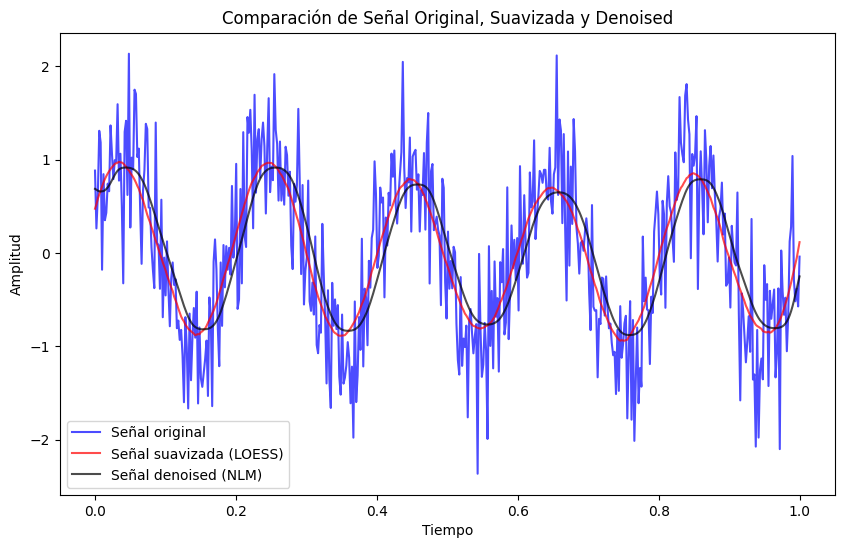

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(time, signal, label="Señal original", color="blue", alpha=0.7)
plt.plot(time, smoothed_signal, label="Señal suavizada (LOESS)", color="red", alpha=0.7)
plt.plot(time, nlm_denoised_signal, label="Señal denoised (NLM)", color="black", alpha=0.7)
plt.xlabel("Tiempo")
plt.ylabel("Amplitud")
plt.legend()
plt.title("Comparación de Señal Original, Suavizada y Denoised")
plt.show()

# **Extracción de los registros correspondientes a bradicardia sinusal y fibrilación auricular (derivación II)**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Se carga el archivo de Excel
file_path = '/content/drive/MyDrive/Diagnostics.xlsx'
df = pd.read_excel(file_path)

In [ ]:
df_SB_AFIB = df[df['Rhythm'].isin(['AFIB','SB'])]
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [ ]:
nombres_filtrados = df_SB_AFIB['FileName'].str.strip().str.lower().tolist()
nombres_filtrados = [f"{name}.csv" if not name.endswith(".csv") else name for name in nombres_filtrados]
data_by_file_sb = {}
data_by_file_afib = {}

folder_path = '/content/drive/MyDrive/ECGData'

dfs_sb = []
dfs_afib = []

for filename in os.listdir(folder_path):
    filename_clean = filename.strip().lower()

    if filename_clean in nombres_filtrados:
        file_path = os.path.join(folder_path, filename)
        file_index = nombres_filtrados.index(filename_clean)
        ritmo = df_SB_AFIB.iloc[file_index]['Rhythm'].lower()

        # Se verifica si el archivo está vacío antes de leer
        if os.stat(file_path).st_size > 0:
            try:

                df = pd.read_csv(file_path, header=None)
                df.columns = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

                df.insert(0, 'FileName', filename)
                df.insert(1, 'Ritmo', ritmo)
                selected_df = df[['FileName', 'Ritmo', 'II']]

                #Se guarda los datos de la columna 'II' en una lista asociada al nombre del archivo
                data_column_ii = selected_df['II'].tolist()

                # Dependiendo del ritmo, se añade al DataFrame correspondiente
                if ritmo == 'sb':
                    data_by_file_sb[filename] = data_column_ii
                    dfs_sb.append(pd.DataFrame({'FileName': filename, 'II': [data_column_ii]}))
                elif ritmo == 'afib':
                    data_by_file_afib[filename] = data_column_ii
                    dfs_afib.append(pd.DataFrame({'FileName': filename, 'II': [data_column_ii]}))
            except pd.errors.EmptyDataError:
                print(f"Advertencia: El archivo {filename} está vacío o no tiene datos válidos.")
        else:
            print(f"Advertencia: El archivo {filename} está vacío y ha sido omitido.")


if len(dfs_sb) == 0 and len(dfs_afib) == 0:
    print("No se encontraron archivos coincidentes o válidos.")
else:

    df_SB= pd.concat(dfs_sb, ignore_index=True) if len(dfs_sb) > 0 else None
    df_AFIB = pd.concat(dfs_afib, ignore_index=True) if len(dfs_afib) > 0 else None

In [ ]:
# Eliminar el primer valor de la columna 'II' en cada fila de df_SB
if df_SB is not None:
    df_SB['II'] = df_SB['II'].apply(lambda x: x[1:] if isinstance(x, list) else x)

pd.set_option('display.max_rows', 5)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [ ]:
# Eliminar el primer valor de la columna 'II' en cada fila de df_AFIB
if df_AFIB is not None:
    df_AFIB['II'] = df_SB['II'].apply(lambda x: x[1:] if isinstance(x, list) else x)

pd.set_option('display.max_rows', 5)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

### Selección de 10 sujetos aleatorios de cada grupo de arritmias

In [ ]:
sujetos_randoms_SB = df_SB.sample(n=10, random_state=1)  # Obtención de 10 sujetos con SB aleatorios

In [ ]:
sujetos_randoms_AFIB = df_AFIB.sample(n=10, random_state=1)  # Obtención de 10 sujetos con AFIB aleatorios

# **Determinación de señal wavelet para el análisis de señales ECG**

La Transformada Wavelet (WT) es una técnica que se usa para el análisis tiempo-frecuencia de señales. Esta transformada descompone las señales en bloques elementales localizados tanto en tiempo como en frecuencia. Esta capacidad de localización permite que la WT caracterice la regularidad local de las señales, lo cual es útil para distinguir elementos indeseados como ruido, artefactos y el desplazamiento de la línea de base al comparar con las ondas características del ECG. Esto permite a la WT tener la capacidad de analizar señales de manera más efectiva que otras transformadas tradicionales, proporcionando un análisis detallado de las variaciones temporales y frecuenciales en las señales ECG [2].

La elección de la función wavelet es crucial para el análisis de señales, ya que cada wavelet posee características particulares que pueden hacerla más adecuada para ciertos tipos de señales o aplicaciones. Por ejemplo, el algoritmo de la wavelet Haar es fácil de comprender y computacionalmente eficiente, pero puede pasar por alto ciertos detalles en comparación con la familia Daubechies (Db). La familia Db es más eficaz para captar detalles en las señales. Además, dentro de la familia Db, una wavelet que no sea adecuada para una señal específica podría ser reemplazada por otra miembro de la misma familia, lo que ofrece flexibilidad en el procesamiento de señales complejas [3].

En particular, la wavelet Daubechies 6 (db6) ha demostrado ser muy efectiva en el procesamiento de señales ECG. Su longitud de filtro y sus valores de coeficientes proporcionan un buen balance entre suavizado y precisión, lo que minimiza el desplazamiento en los puntos de referencia del ECG. Esto permite una detección más precisa de las ondas P y T, que son esenciales para el análisis detallado de la señal ECG. Además, se hace uso de un nivel de descomposición 4, ya que mostró ser la mejor opción para el filtrado de señales ECG debido a su efectividad en la reducción de ruido a frecuencias bajas sin eliminar información importante de la señal de interés [3][4][5].

## Implementación del filtro wavelet seleccionado (Daubechies 6, nivel 4)

In [ ]:
import pywt
from statsmodels.robust import mad

# Ponderación de los umbrales
def wnoisest(coeff):
    stdc = np.zeros((len(coeff),1));
    for i in range(0,len(coeff)):
      # Sigma, con el el que se ponderalizar el umbral
        stdc[i] = (np.median(np.absolute(coeff[i])))/0.6745;
    return stdc;

# Umbral universal
def threshold(coeff):
    Num_samples = 0;
    for i in range(0,len(coeff)):
        Num_samples = Num_samples + coeff[i].shape[0];
    # Ecuación para el umbral universal
    thr = np.sqrt(2*(np.log(Num_samples)))
    return thr

# Umbralizar los detalles
def wthresh(coeff):
    y   = list();
    s = wnoisest(coeff);
    thr = threshold(coeff)
    for i in range(0,len(coeff)):
        y.append(np.multiply(coeff[i],np.abs(coeff[i])>(thr*s[i])));
    return thr,s,y;

In [ ]:
def wavelet(signal, tipo_wavelet):
  data = np.squeeze(signal)
  wavelet = pywt.Wavelet(tipo_wavelet)
  num_points = wavelet.dec_len
  levels = int(np.floor((np.log2(data.shape[0]/num_points))-1));
  data_wavelet = pywt.wavedec( data, tipo_wavelet, level=4);

  details = data_wavelet[1:]
  thr, s, details_t = wthresh(details);
  coeff = list()
  coeff.append(data_wavelet[0])
  for i in range(len(details_t)):
    coeff.append(details_t[i])
  x_rec = pywt.waverec(coeff, tipo_wavelet);
  x_rec = x_rec[0:data.shape[0]];
  return x_rec

# **Flujos de procesamiento**

### **Flujo 1**

  * Filtro pasa-altas usando filtro IIR a 0.5 Hz. Justificar la elección de parámetros

  * Filtro wavelet modificado del punto 3

  * Filtrado pasabajas 50 Hz. Justificar la elección de parámetros

In [ ]:
def flujo_1(data):
  # Parámetros de los filtros
  fs = 500
  order = 3  # Orden de los filtros lineales
  nyquist = fs/2  # Frecuencia de Nyquist
  highcuttof = 0.5/nyquist  # Frecuencia de corte normalizada
  lowcuttof = 50/nyquist

  # Parámetros de wavelet
  wavelet_type = 'db6'
  level = 4  # Nivel de descomposición

  # Crear el filtro pasa-altas
  b_high_F1, a_high_F1 = signal.iirfilter(order, highcuttof, btype='highpass', analog=False, ftype = 'butter')
  # Crear el filtro pasa-bajas
  b_low_F1, a_low_F1 = signal.iirfilter(order, lowcuttof, btype='lowpass', analog=False, ftype = 'butter')


  # Aplicación del filtro pasa altas
  señal_high_F1 = signal.filtfilt(b_high_F1, a_high_F1, data)

  # Aplicación del filtro Wavelet
  señal_wavelet_F1 = wavelet(señal_high_F1, 'db6')

  # Aplicación del filtro pasa bajas
  señal_filtrada_F1 = signal.filtfilt(b_low_F1, a_low_F1, señal_wavelet_F1)

  return señal_filtrada_F1

### **Flujo 2**

  * Detrend

  * Filtro wavelet modificado del punto 3

  * Filtrado pasabajas 50 Hz. Justificar la elección de parámetros


In [ ]:
def flujo_2(data):
  # Parámetros de los filtros
  fs = 500
  order = 3  # Orden de los filtros lineales
  nyquist = fs/2  # Frecuencia de Nyquist
  lowcuttof = 50/nyquist

  # Parámetros de wavelet
  wavelet_type = 'db6'
  level = 4  # Nivel de descomposición

  # Crear el filtro pasa-bajas
  b_low_F2, a_low_F2 = signal.iirfilter(order, lowcuttof, btype='lowpass', analog=False, ftype = 'butter')

  # Detrending
  señal_detrended_F2 = signal.detrend(data)

  # Aplicación del filtro Wavelet
  señal_wavelet_F2 = wavelet(señal_detrended_F2, 'db6')

  # Aplicación del filtro pasa bajas
  señal_filtrada_F2 = signal.filtfilt(b_low_F2, a_low_F2, señal_wavelet_F2)

  return señal_filtrada_F2

### **Flujo 3**

  * Filtro pasa-altas usando filtro IIR a 0.5 Hz. Justificar la elección de parámetros

  * Filtrado pasabajas 50 Hz. Justificar la elección de parámetros

In [ ]:
def flujo_3(data):
  # Parámetros de los filtros
  fs = 500
  order = 3  # Orden de los filtros lineales
  nyquist = fs/2  # Frecuencia de Nyquist
  highcuttof = 0.5/nyquist  # Frecuencia de corte normalizada
  lowcuttof = 50/nyquist

  # Crear el filtro pasa-altas
  b_high_F3, a_high_F3 = signal.iirfilter(order, highcuttof, btype='highpass', analog=False, ftype = 'butter')
  # Crear el filtro pasa-bajas
  b_low_F3, a_low_F3 = signal.iirfilter(order, lowcuttof, btype='lowpass', analog=False, ftype = 'butter')

  # Aplicación del filtro pasa altas
  señal_high_F3 = signal.filtfilt(b_high_F3, a_high_F3, data)

  # Aplicación del filtro pasa bajas
  señal_filtrada_F3 = signal.filtfilt(b_low_F3, a_low_F3, señal_high_F3)

  return señal_filtrada_F3

## **Justificación de la elección de parámetros implementados en los 3 flujos**

### **Filtros IIR**

Un filtro IIR (Infinite Impulse Response) es aquel que tiene una respuesta infinita al impulso, lo que significa que su salida depende no solo de las entradas actuales y anteriores, sino también de las salidas previas. Es decir, se trata de filtros recursivos, ya que poseen retroalimentación (realimentación) de la señal de salida, generando una respuesta impulsional infinita en el tiempo [6].

La principal ventaja de los filtros IIR frente a los filtros FIR (Finite Impulse Response) es que, con un orden de filtro más bajo, pueden cumplir un conjunto determinado de especificaciones de manera más eficiente. Esto se debe a que los filtros IIR pueden alcanzar un rendimiento similar al de los filtros FIR con un número significativamente menor de coeficientes, lo que implica menor complejidad computacional y menores requisitos de memoria [7].


### **Filtro pasa altas (IIR - 0.5Hz) y filtro pasa bajas (IIR - 50Hz)**

Es importante tener en cuenta que los filtros IIR de orden alto pueden volverse inestables. Esto sucede porque la presencia de polos cercanos al borde del círculo unitario en el plano Z puede causar un crecimiento sin límite en la respuesta en frecuencia, llevando a una inestabilidad del filtro. Para evitar estos problemas, es fundamental seleccionar un orden adecuado [5]. por lo que, en este caso, se implementó un filtro IIR de orden 3 que permite obtener una respuesta adecuada sin generar inestabilidad en el sistema. Un filtro de orden más alto podría aumentar la posibilidad de inestabilidad y acumulación de errores, mientras que un filtro de orden 3 garantiza un equilibrio entre rendimiento y estabilidad, permitiendo una graficación adecuada de los resultados sin comprometer la precisión del filtrado. Para confirmar esto se realizaron diagramas de Bode evaluando posibles órdenes a implementar para la realización de los filtros lineales.


* **Topología:** En general existen muchos tipos de filtros empleados en los sistemas de adquisicón de ECG, entre ellos, la aproximación de Butterworth es la más usada porque permite la obtención de una mejor fase linear proporciona una mejor fase lineal y una respuesta plana dentro de cada ancho de banda [8].
* La implementación de los filtros pasa altas y pasa bajas equivalen a tener un resultado final de un filtro pasa bandas entre 0.5 y 50 Hz, lo que es apropiado para el análisis de señales ECG debido a que en esta banda se encuentran sus frecuencias representativas [9]. Además, esto permite eliminar la posible presencia del ruido eléctrico que es muy común en la adquisición de señales fisiológicas, causante de una distorsión significativa, afectando la precisión de los análisis [10]

### **Filtro Wavelet**

* **Tipo:** Daubechies 6
* **Nivel:** 4



### Comparación de órdenes para filtros IIR mediante diagramas de Bode

In [ ]:
from scipy import signal
def diagrama_bode(b_list, a_list, orders, nyq_rate=1):
    plt.figure(figsize=(20, 5))

    # Magnitud
    plt.subplot(131)
    for b, a, order in zip(b_list, a_list, orders):
        w, h = signal.freqz(b, a)
        plt.plot((w / max(w)) * nyq_rate, abs(h), label=f"Orden: {order}")
    plt.ylabel('Magnitud')
    plt.xlabel(r'Frecuencia Normalizada (xrad/muestra)')
    plt.title(r'Respuesta en Frecuencia')
    plt.legend()
    plt.grid(True)

    # Magnitud (dB)
    plt.subplot(132)
    for b, a, order in zip(b_list, a_list, orders):
        w, h = signal.freqz(b, a)
        h_dB = 20 * np.log10(abs(h))
        plt.plot((w / max(w)) * nyq_rate, h_dB, label=f"Orden: {order}")
    plt.ylabel('Magnitud (dB)')
    plt.xlabel(r'Frecuencia Normalizada (xrad/muestra)')
    plt.title(r'Respuesta en Magnitud (dB)')
    plt.legend()
    plt.grid(True)

    # Fase
    plt.subplot(133)
    for b, a, order in zip(b_list, a_list, orders):
        w, h = signal.freqz(b, a)
        h_Phase = np.unwrap(np.arctan2(np.imag(h), np.real(h)))
        plt.plot((w / max(w)) * nyq_rate, h_Phase, label=f"Orden: {order}")
    plt.ylabel('Fase (radianes)')
    plt.xlabel(r'Frecuencia Normalizada (xrad/muestra)')
    plt.title(r'Respuesta en Fase')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

### Diagrama de Bode para filtro pasa altas



<ipython-input-25-d2335419fb37>:20: RuntimeWarning: divide by zero encountered in log10
  h_dB = 20 * np.log10(abs(h))


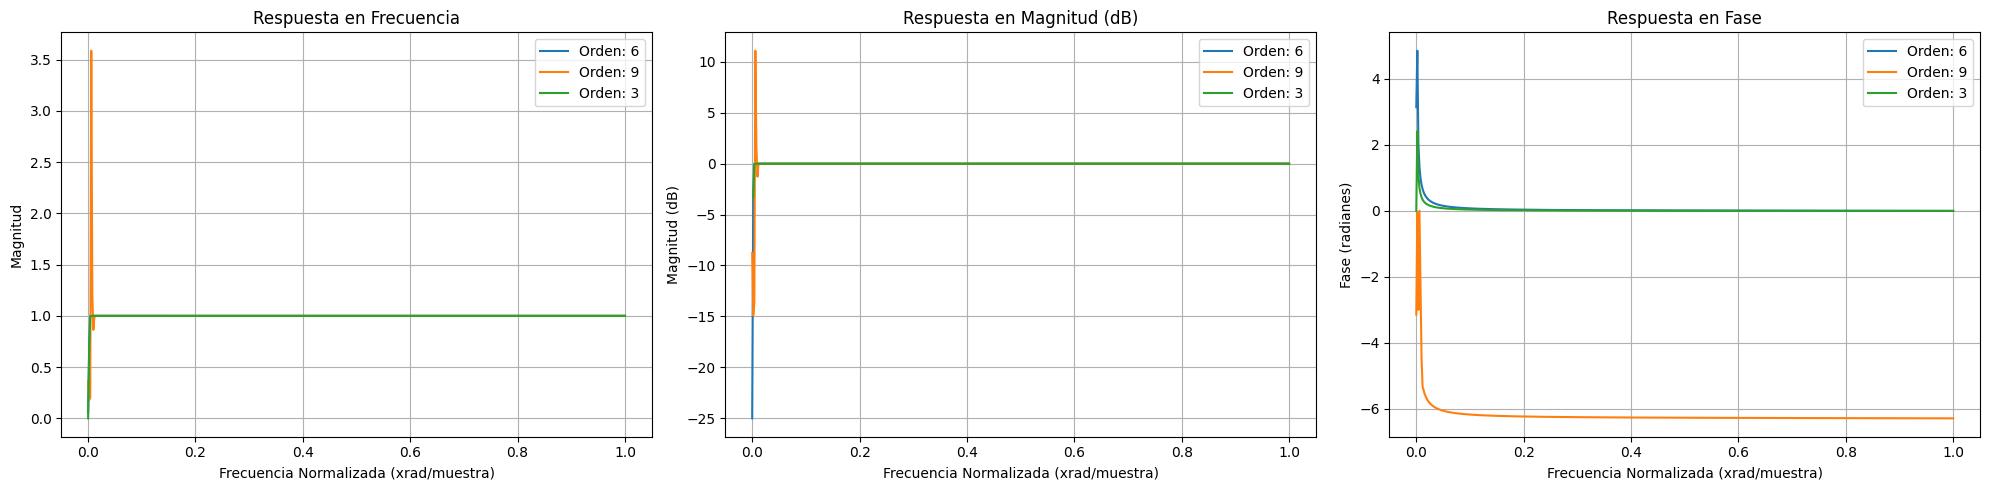

In [ ]:
Fs = 500
nyquist = Fs / 2
high_cutoff = 0.5 / nyquist

b_high_3, a_high_3 = signal.iirfilter(3, high_cutoff, btype='highpass', analog=False, ftype='butter')
b_high_6, a_high_6 = signal.iirfilter(6, high_cutoff, btype='highpass', analog=False, ftype='butter')
b_high_9, a_high_9 = signal.iirfilter(9, high_cutoff, btype='highpass', analog=False, ftype='butter')

diagrama_bode([b_high_6, b_high_9, b_high_3], [ a_high_6, a_high_9, a_high_3], [6, 9, 3])

### Diagrama de Bode para filtro pasa bajas

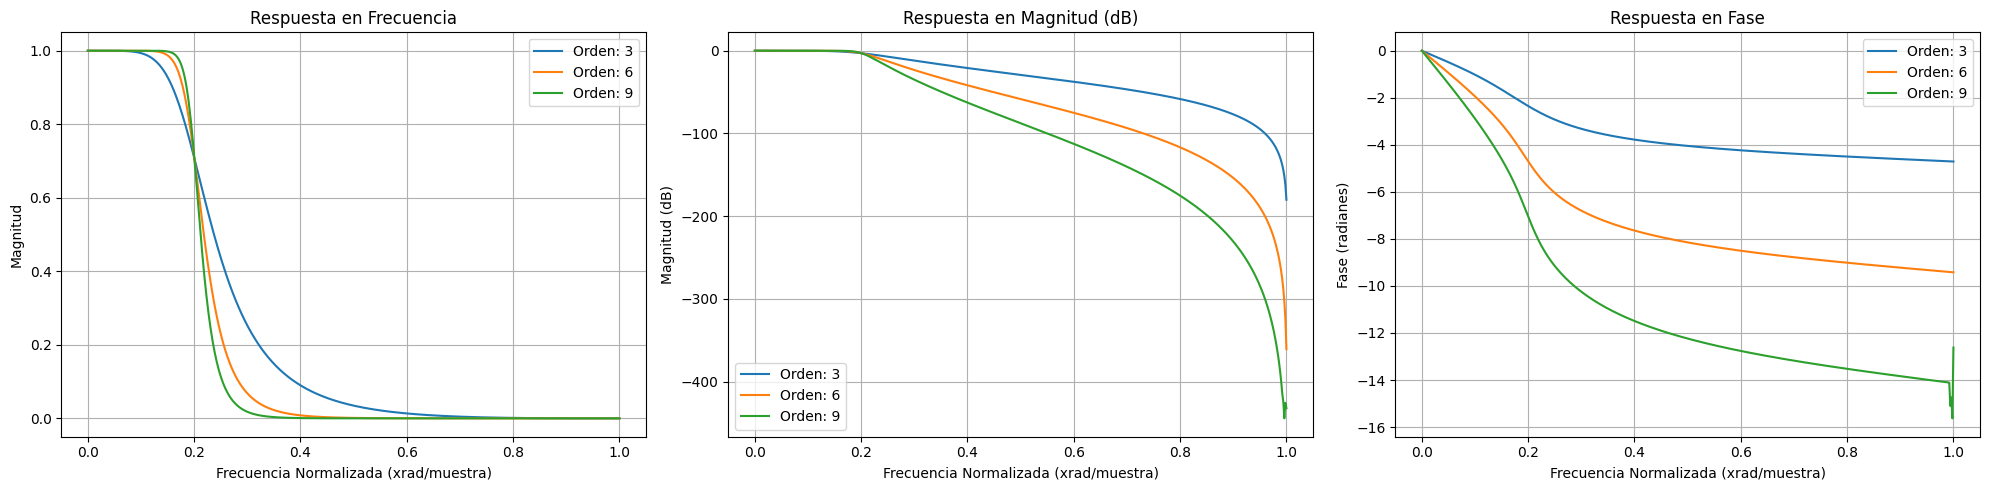

In [ ]:
low_cuttof = 50 / nyquist
b_low_3, a_low_3 = signal.iirfilter(3, low_cuttof, btype='lowpass', analog=False, ftype = 'butter')
b_low_6, a_low_6 = signal.iirfilter(6, low_cuttof, btype='lowpass', analog=False, ftype = 'butter')
b_low_9, a_low_9 = signal.iirfilter(9, low_cuttof, btype='lowpass', analog=False, ftype = 'butter')

diagrama_bode([b_low_3, b_low_6, b_low_9], [a_low_3, a_low_6, a_low_9], [3, 6, 9])

En los diagramas de Bode realizados para filtros pasa altas y pasa bajas tipo IIR, se evidencia que un mayor orden produce una disminución de la selectividad del filtro ya que la banda de transición se vuelve más suave. Por esto, se seleccionó como el orden 3 como el más adecuado ya que tiene una banda de transición abrupta que permite separar con severidad la banda de paso de la banda de rechazo según la frecuencia de corte. Además, la selección de un órden más bajo permite garantizar un equilibrio entre rendimiento y estabilidad, permitiendo una graficación adecuada de los resultados sin comprometer la precisión del filtrado.

# **Análisis de flujos de procesamiento de señales ECG: elección del flujo óptimo**

### Implementación de flujos para 10 sujetos aleatorios con SB

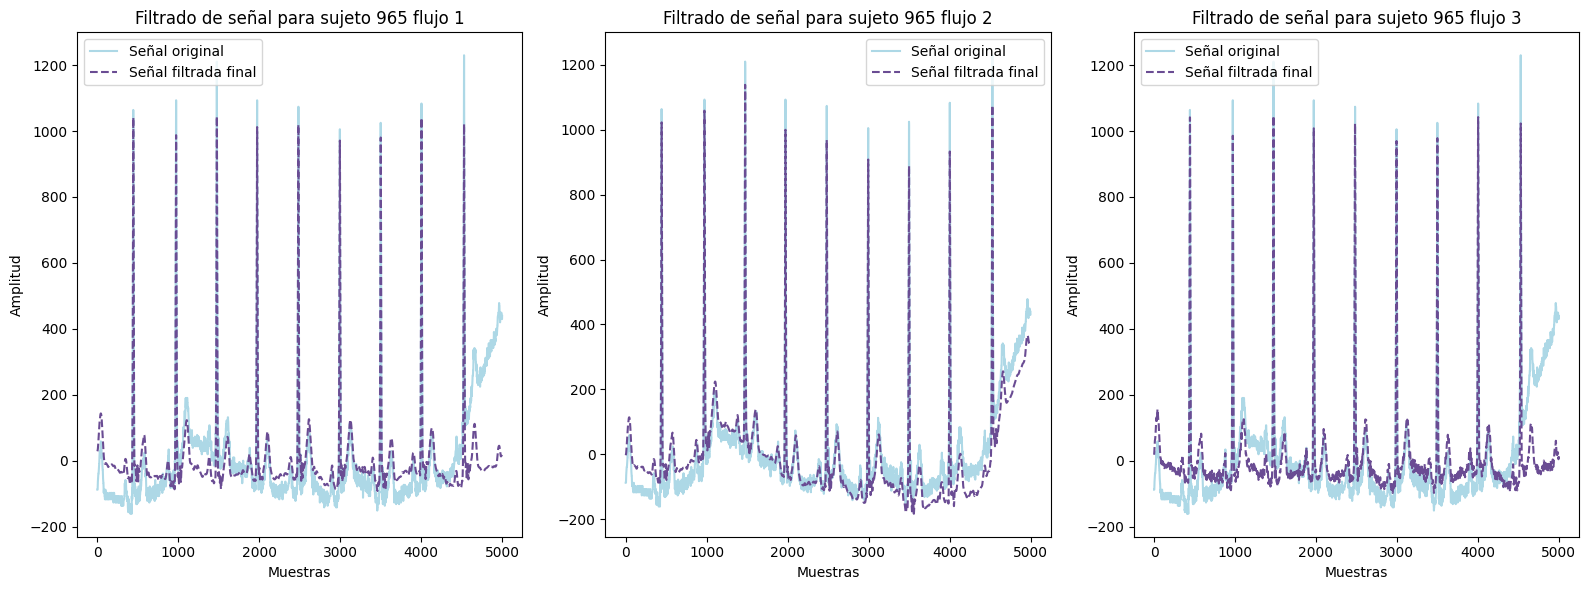

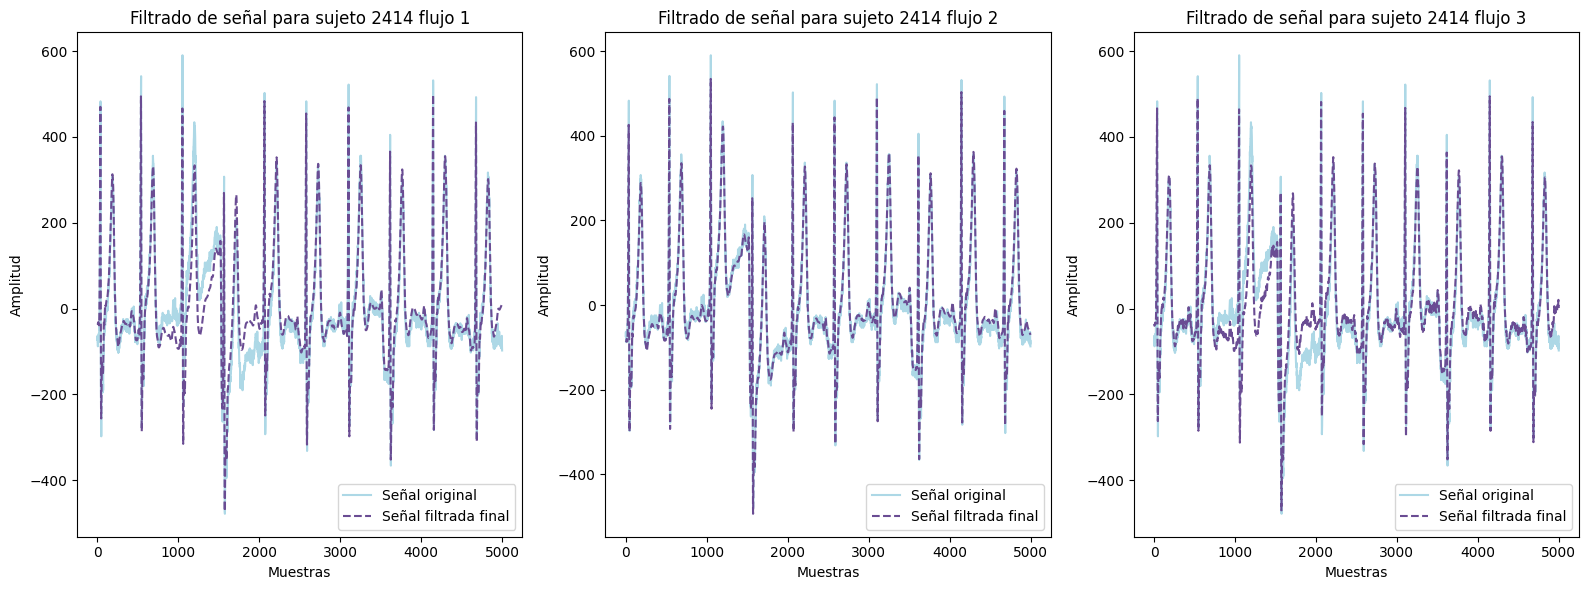

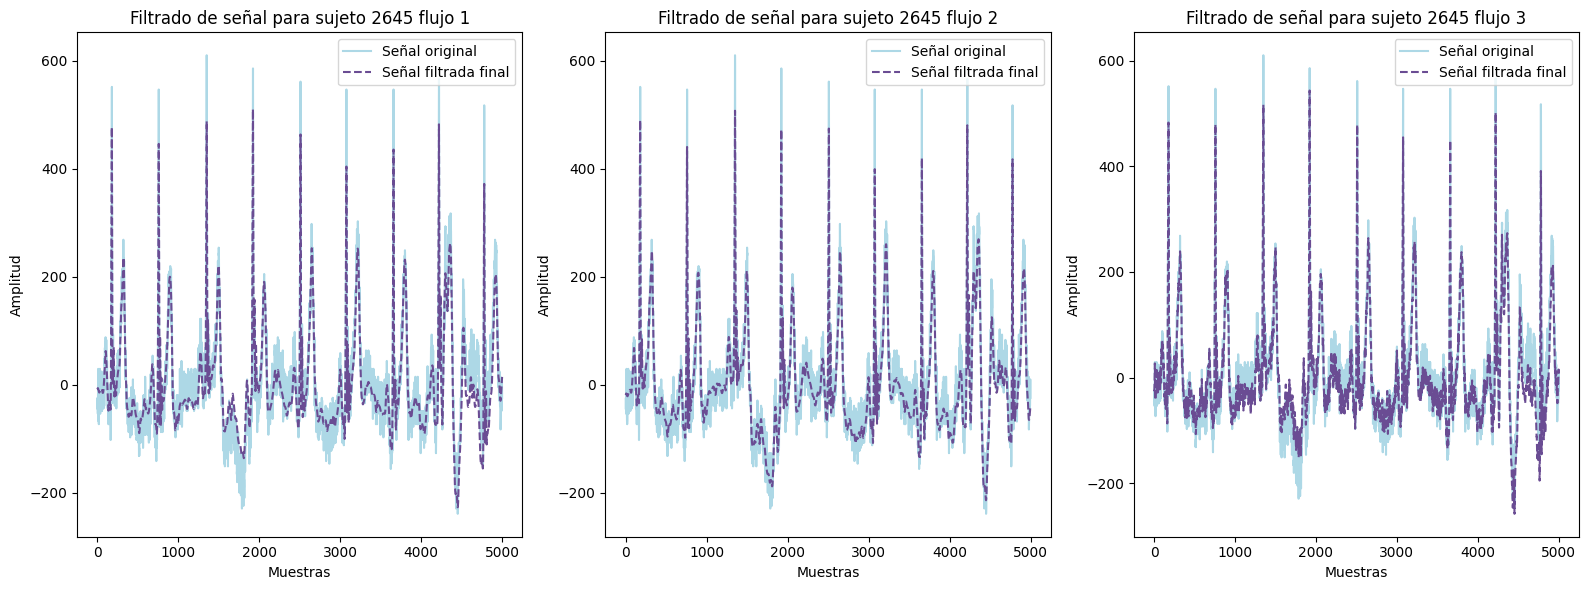

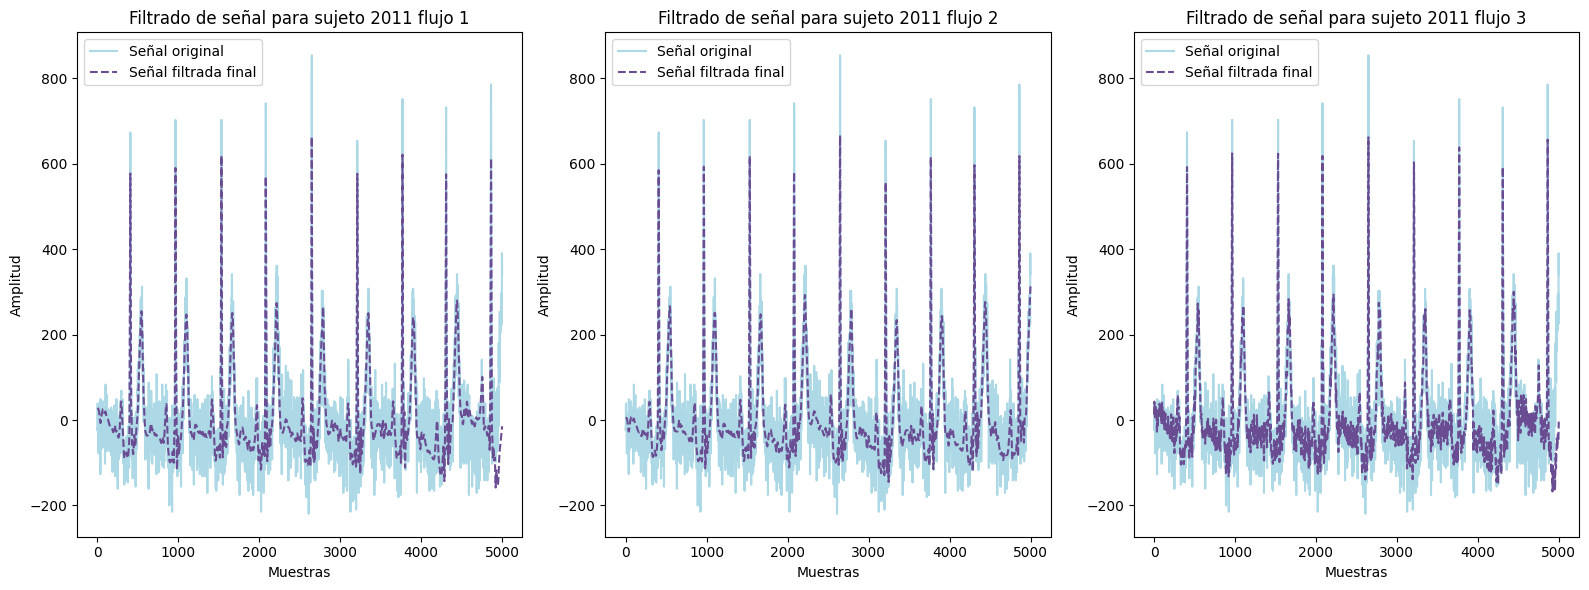

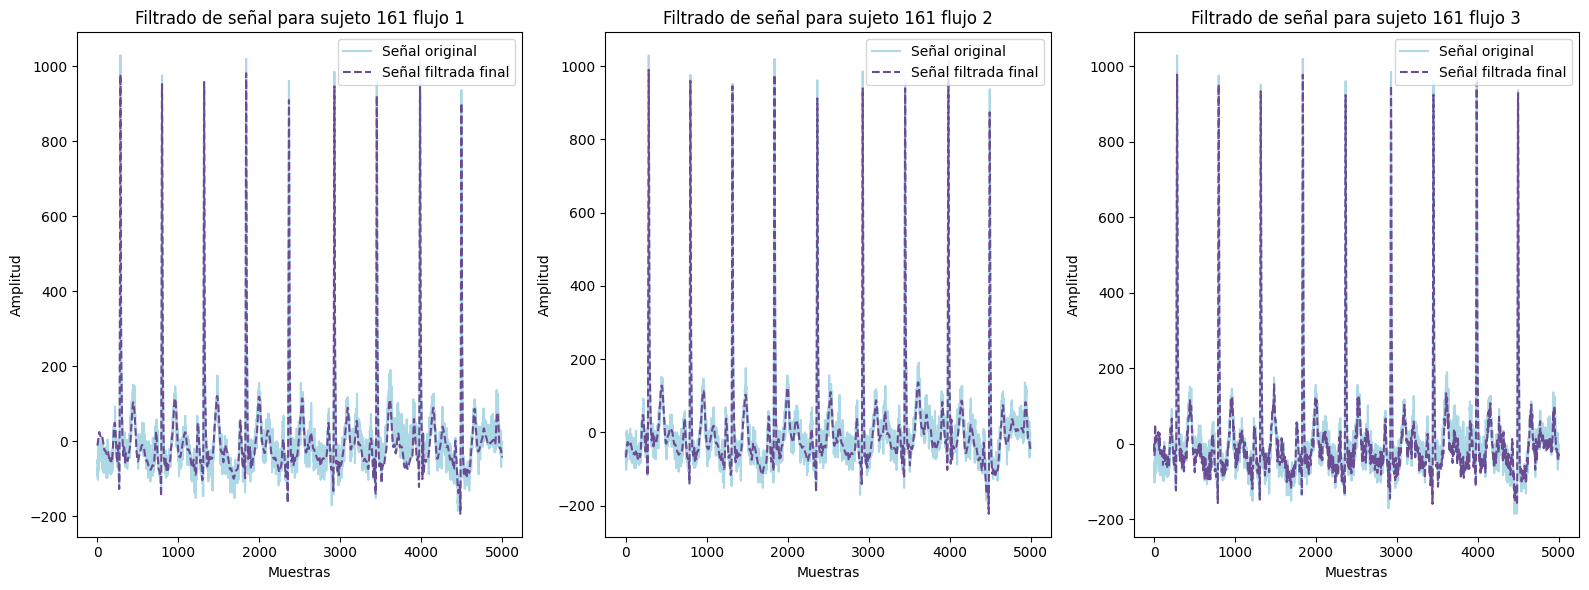

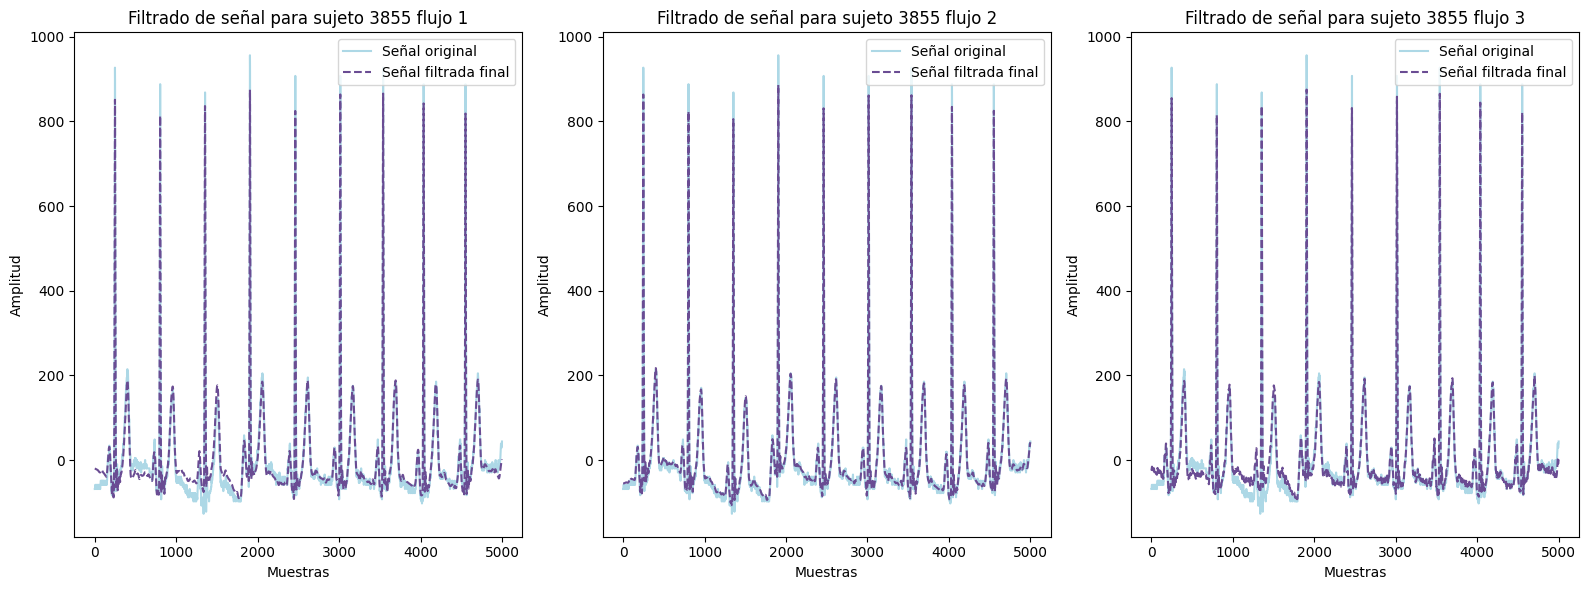

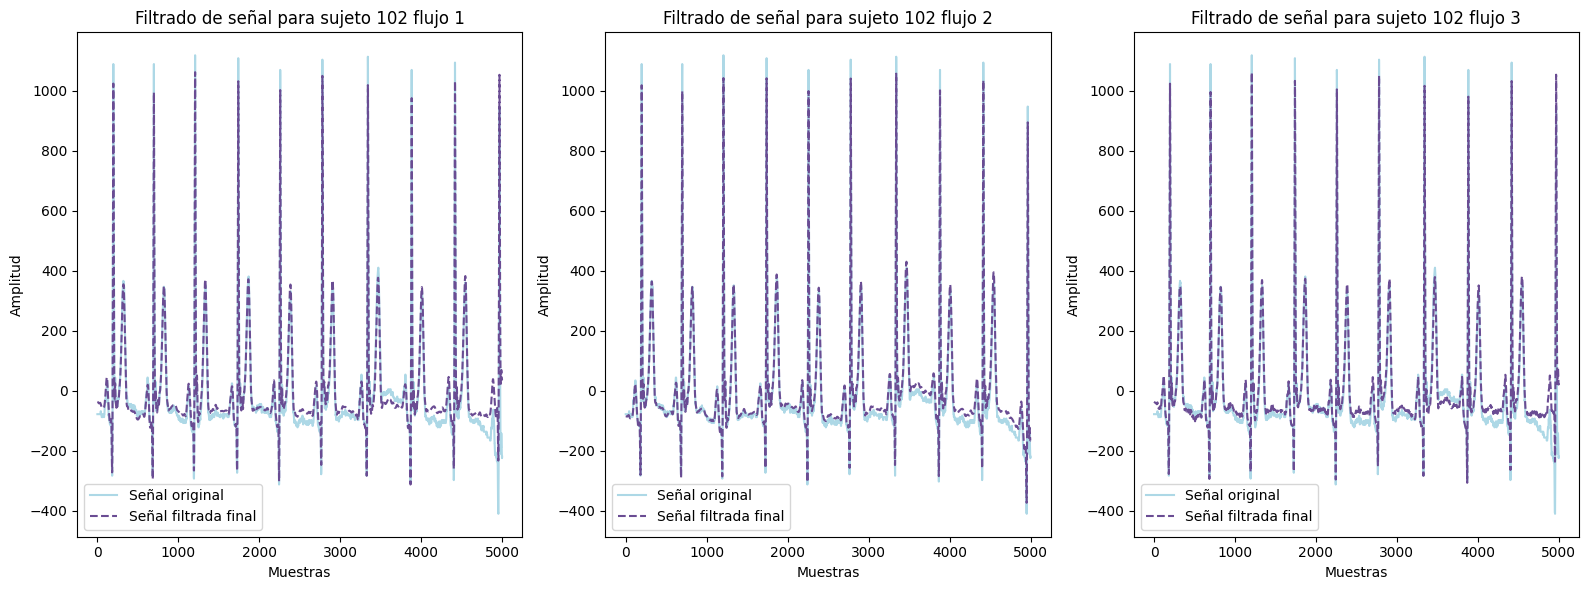

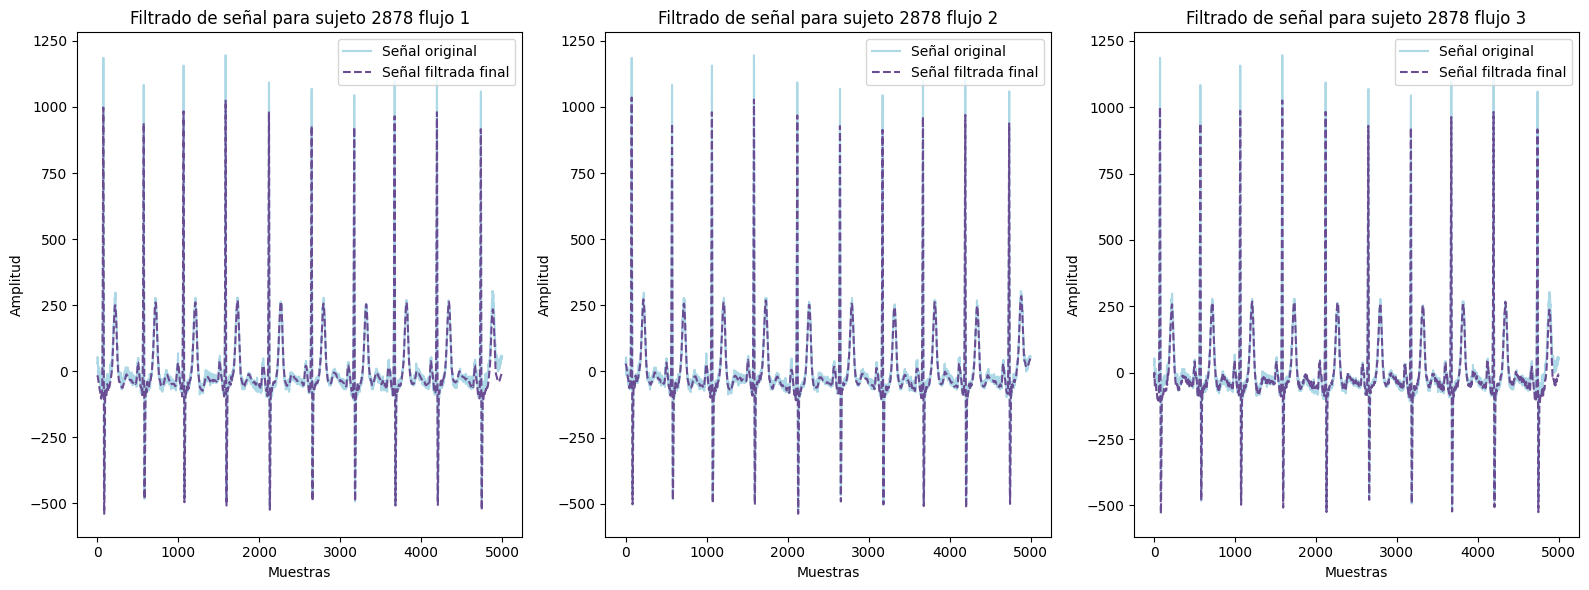

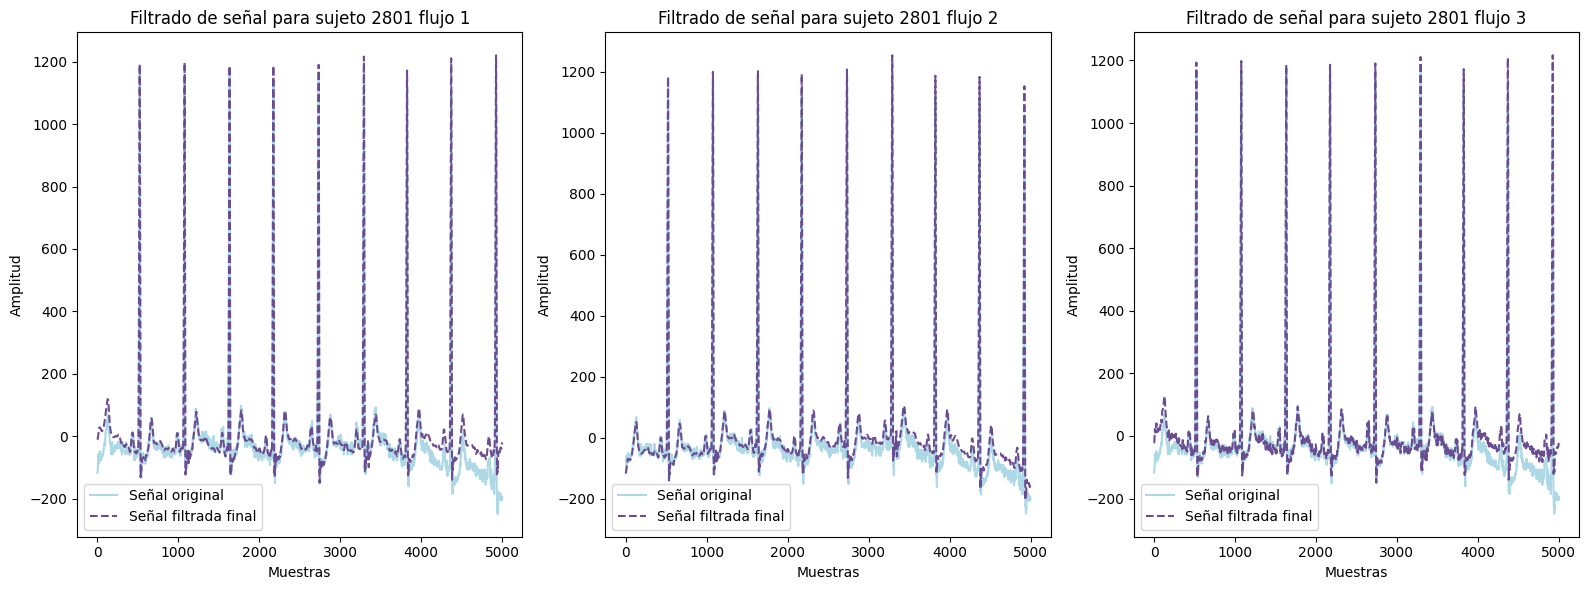

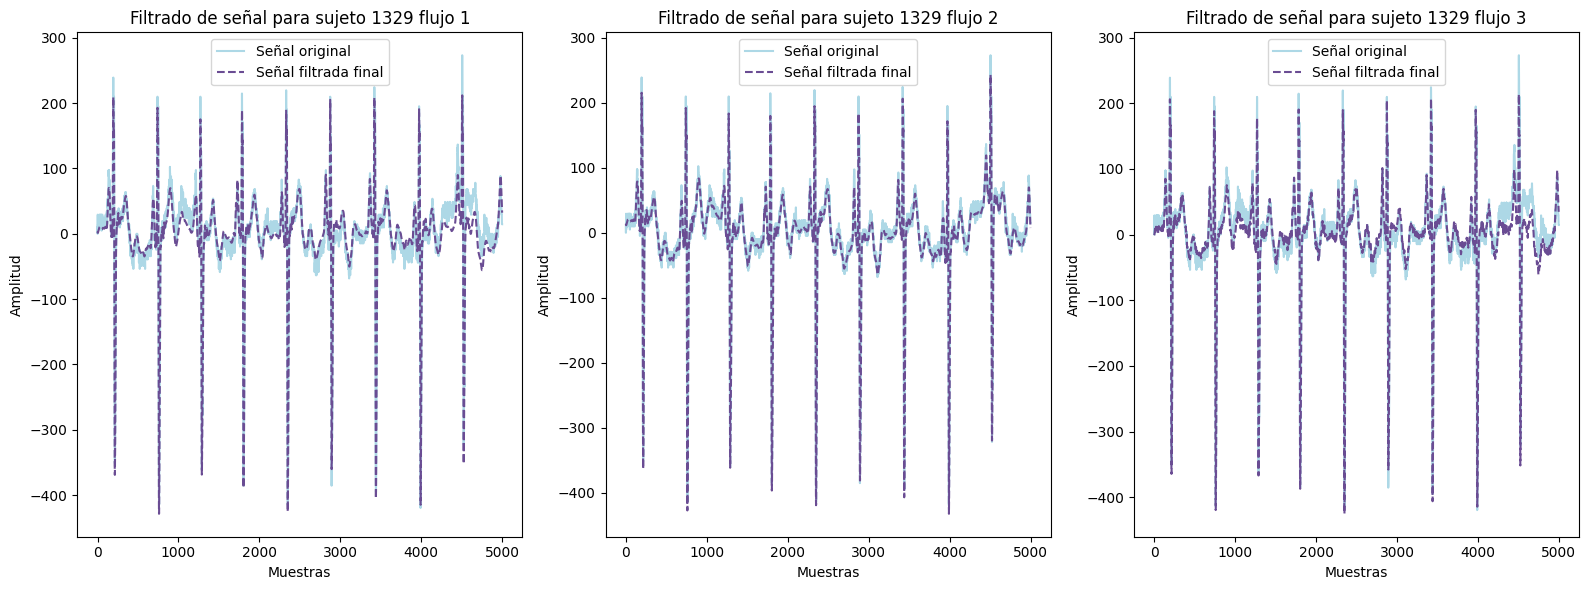

In [ ]:
from scipy import signal

for index, row in sujetos_randoms_SB.iterrows():

    señal_original = np.array(row['II'], dtype=float)
    signal_F1 = flujo_1(señal_original)
    signal_F2 = flujo_2(señal_original)
    signal_F3 = flujo_3(señal_original)


    plt.figure(figsize=(16, 6))

    plt.subplot(1, 3, 1) #Flujo 1
    plt.plot(señal_original, label='Señal original', color='lightblue')
    plt.plot(signal_F1, label='Señal filtrada final', linestyle='--', color='#6A4C93')
    plt.xlabel('Muestras')
    plt.ylabel('Amplitud')
    plt.legend()
    plt.title(f'Filtrado de señal para sujeto {index} flujo 1')

    plt.subplot(1, 3, 2) #Flujo 2
    plt.plot(señal_original, label='Señal original', color='lightblue')
    plt.plot(signal_F2, label='Señal filtrada final', linestyle='--', color='#6A4C93')
    plt.xlabel('Muestras')
    plt.ylabel('Amplitud')
    plt.legend()
    plt.title(f'Filtrado de señal para sujeto {index} flujo 2')

    plt.subplot(1, 3, 3) #Flujo 3
    plt.plot(señal_original, label='Señal original', color='lightblue')
    plt.plot(signal_F3, label='Señal filtrada final', linestyle='--', color='#6A4C93')
    plt.xlabel('Muestras')
    plt.ylabel('Amplitud')
    plt.legend()
    plt.title(f'Filtrado de señal para sujeto {index} flujo 3')

    plt.tight_layout()
    plt.show()

### Implementación de flujos para 10 sujetos aleatorios con AFIB

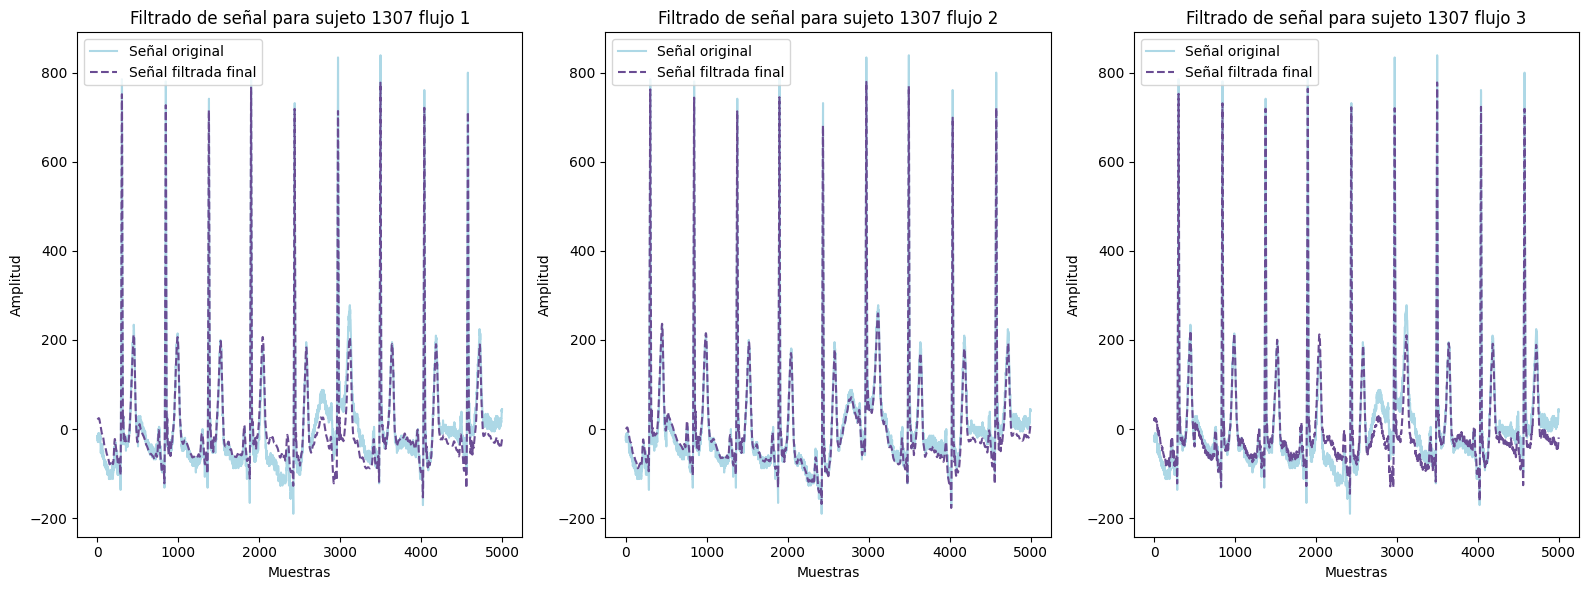

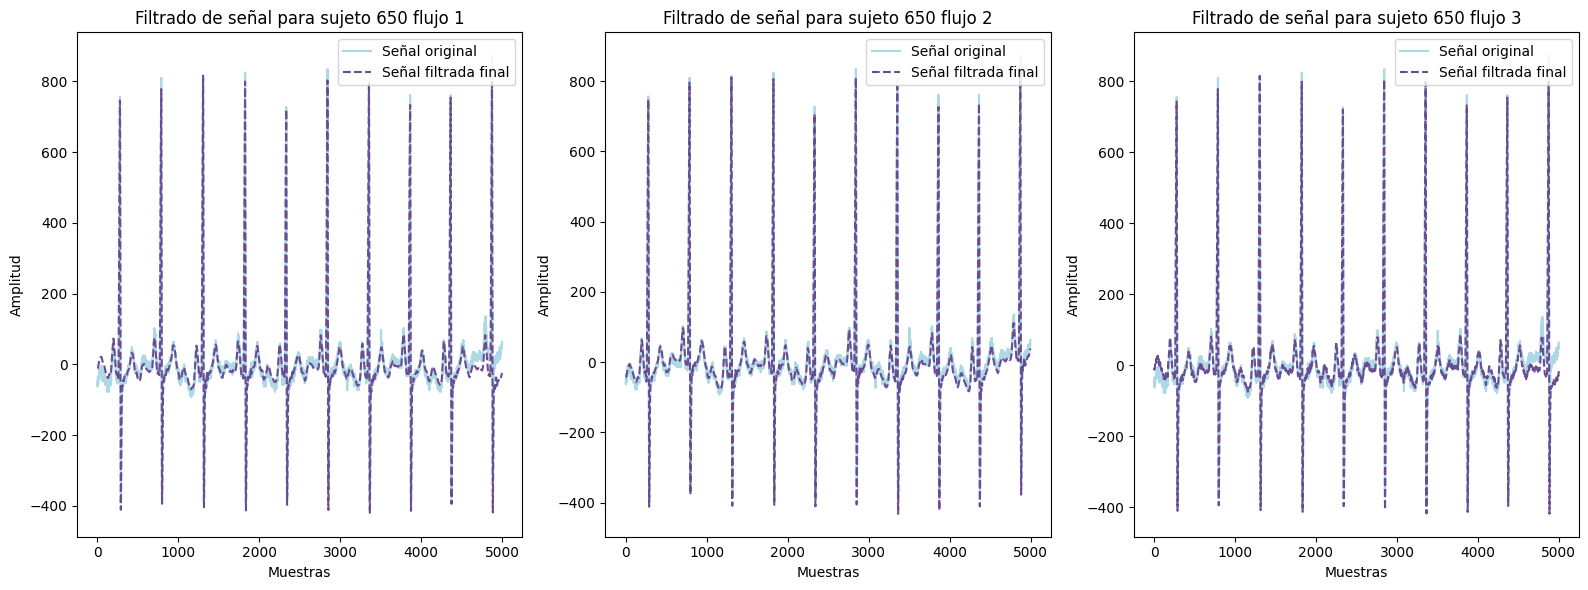

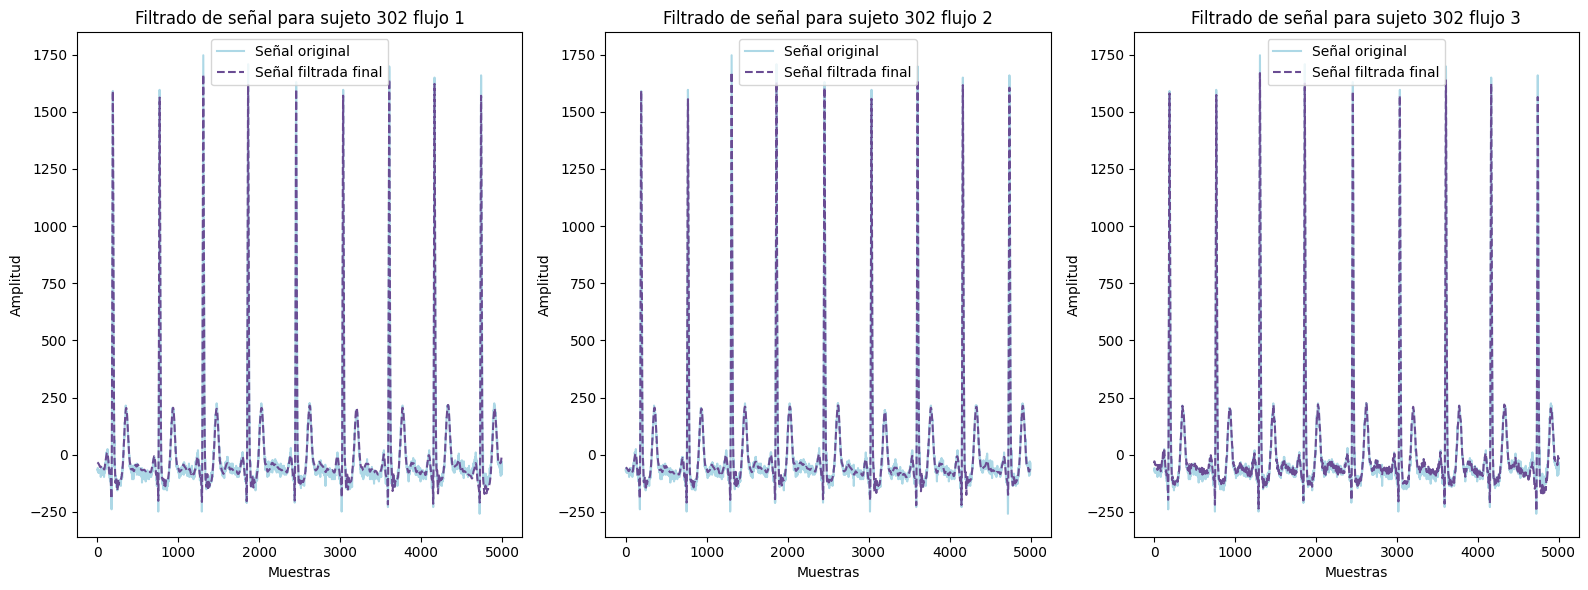

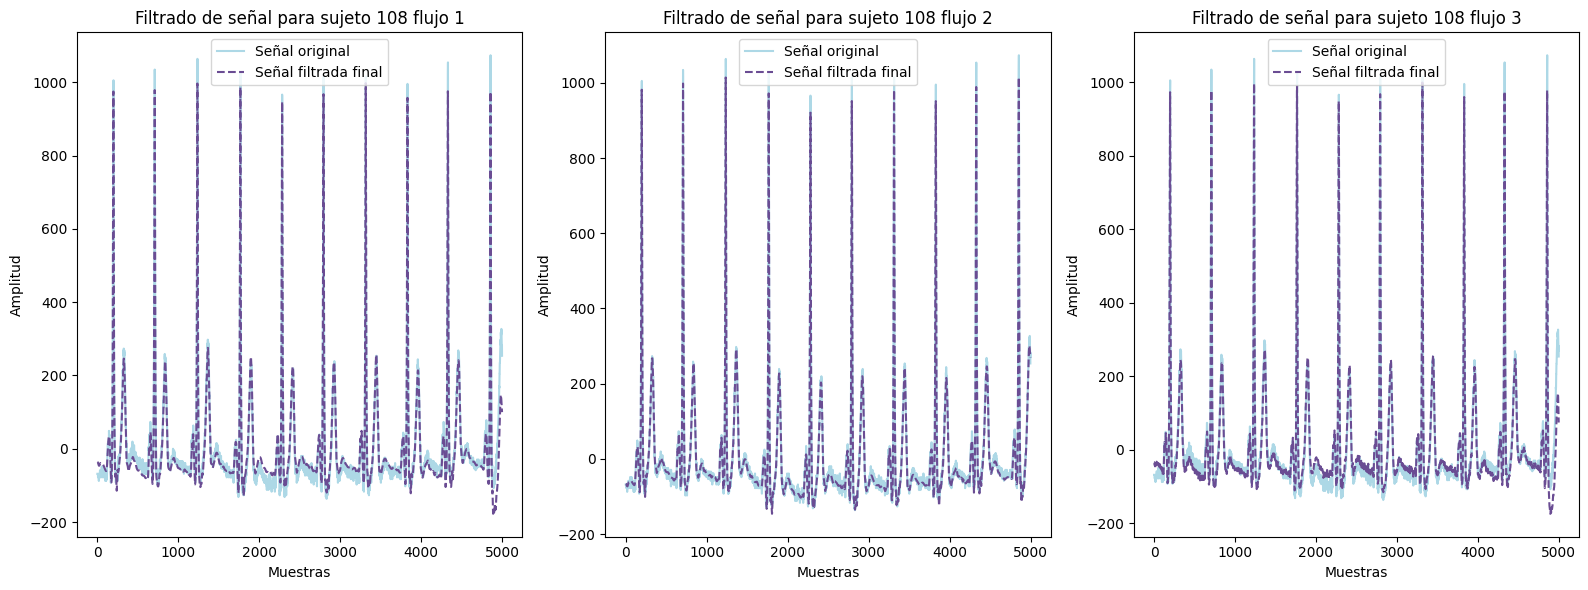

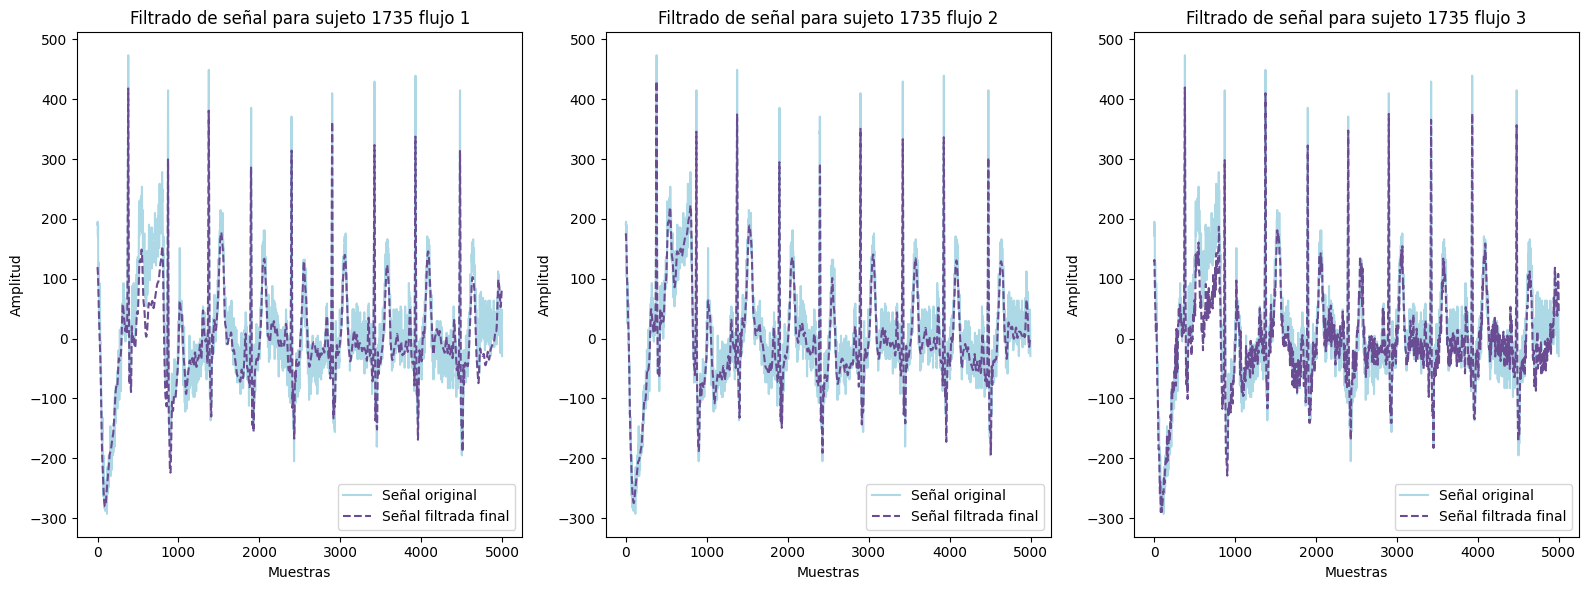

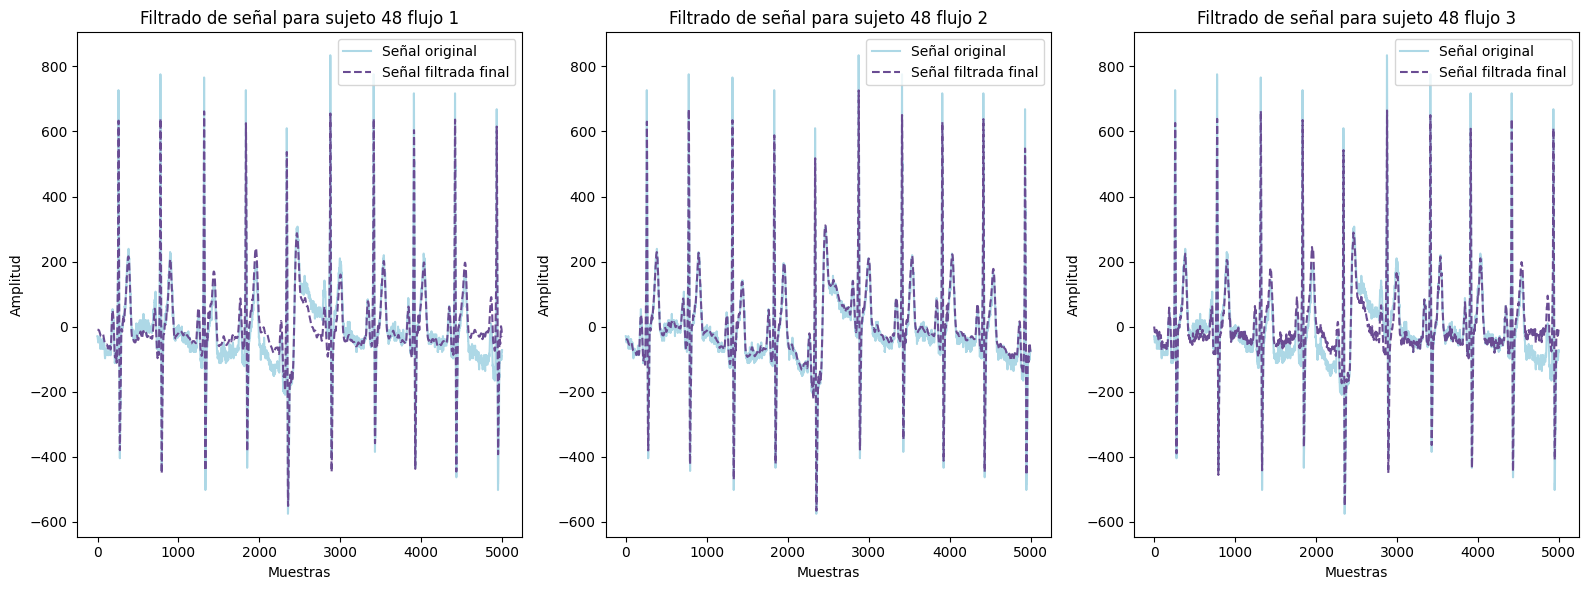

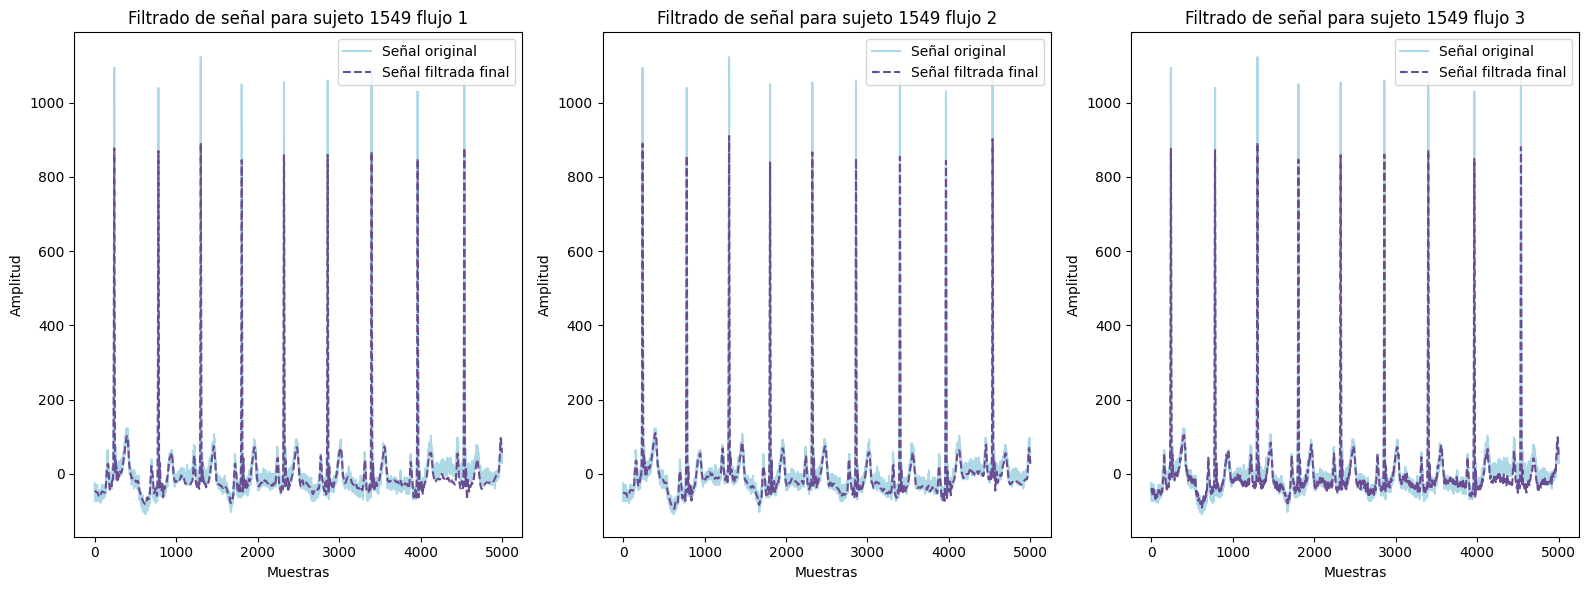

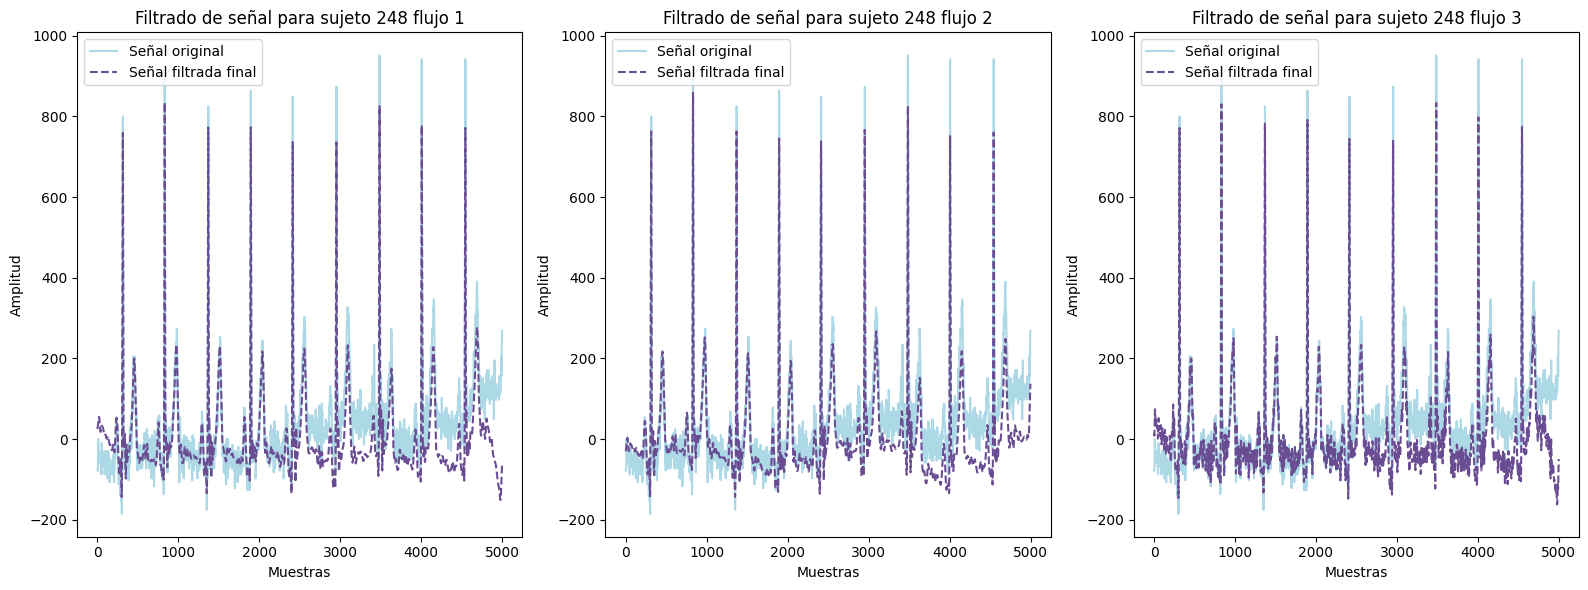

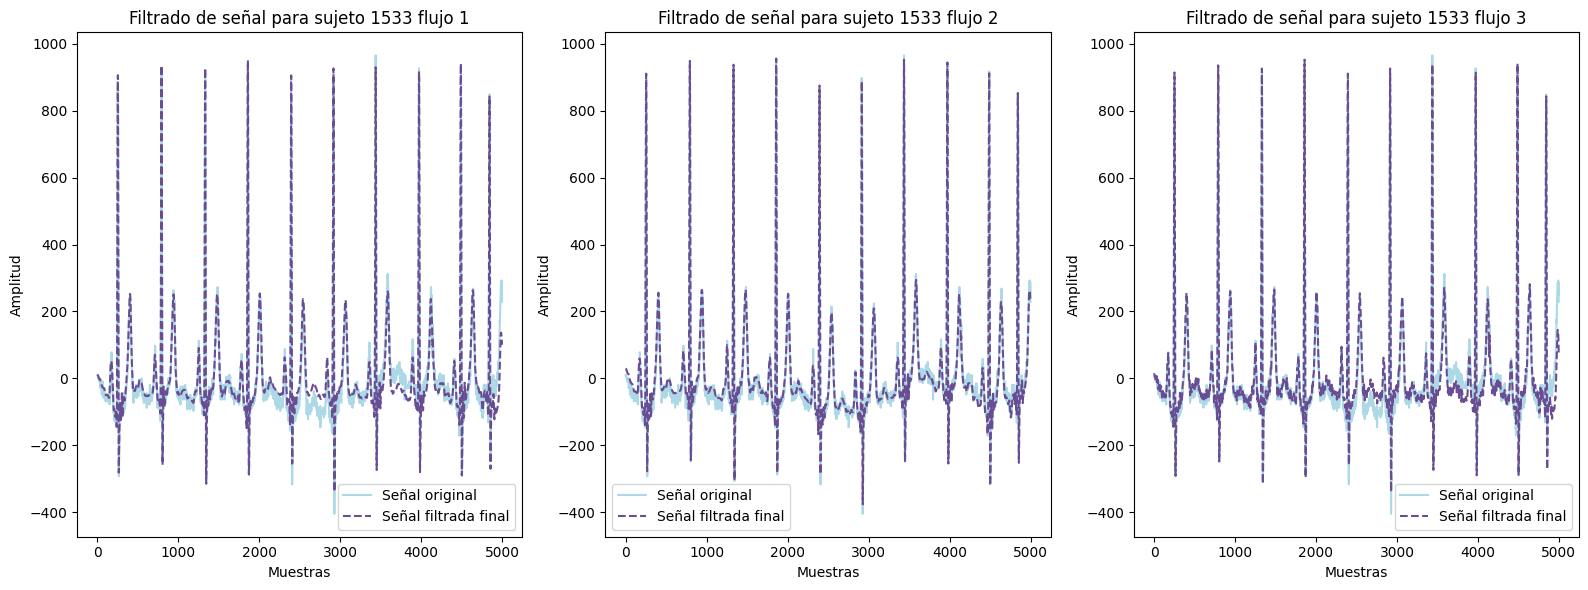

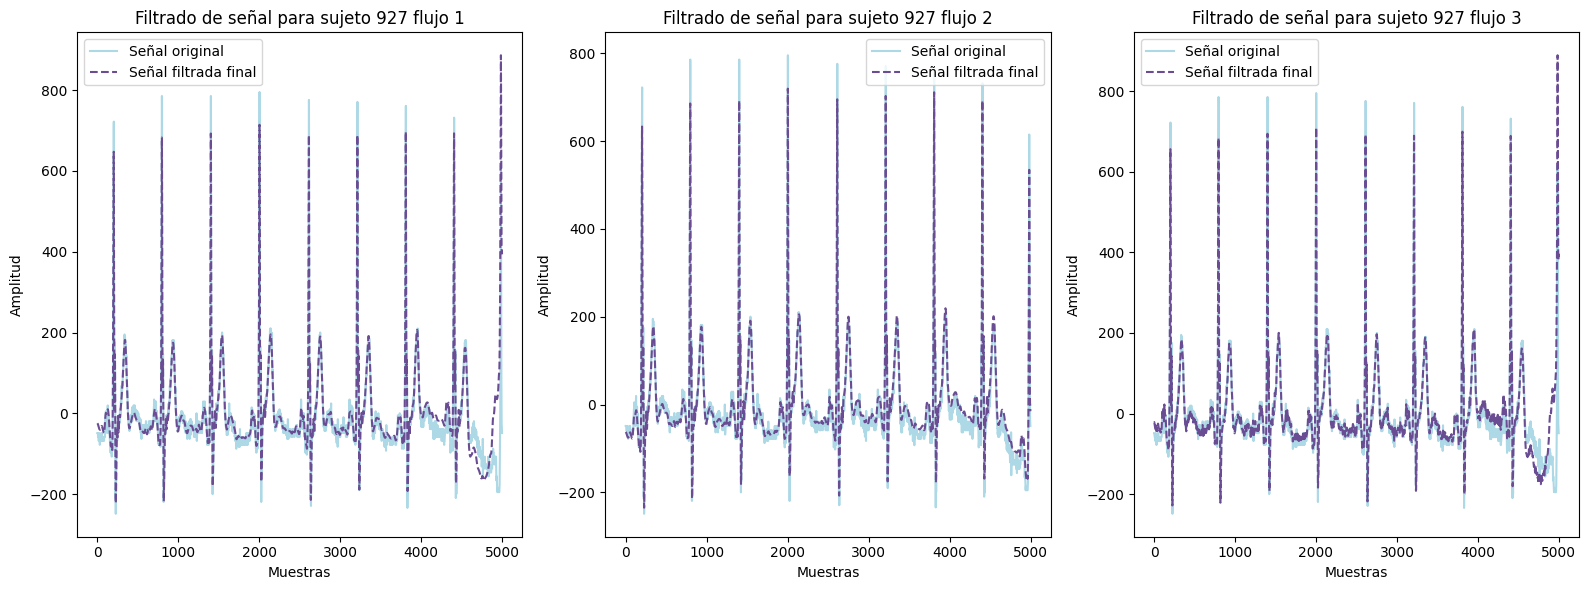

In [ ]:
for index, row in sujetos_randoms_AFIB.iterrows():

    señal_original_AFIB = np.array(row['II'], dtype=float)
    signal_F1_AFIB = flujo_1(señal_original_AFIB)
    signal_F2_AFIB = flujo_2(señal_original_AFIB)
    signal_F3_AFIB = flujo_3(señal_original_AFIB)


    plt.figure(figsize=(16, 6))

    plt.subplot(1, 3, 1) #Flujo 1
    plt.plot(señal_original_AFIB, label='Señal original', color='lightblue')
    plt.plot(signal_F1_AFIB, label='Señal filtrada final', linestyle='--', color='#6A4C93')
    plt.xlabel('Muestras')
    plt.ylabel('Amplitud')
    plt.legend()
    plt.title(f'Filtrado de señal para sujeto {index} flujo 1')

    plt.subplot(1, 3, 2) #Flujo 2
    plt.plot(señal_original_AFIB, label='Señal original', color='lightblue')
    plt.plot(signal_F2_AFIB, label='Señal filtrada final', linestyle='--', color='#6A4C93')
    plt.xlabel('Muestras')
    plt.ylabel('Amplitud')
    plt.legend()
    plt.title(f'Filtrado de señal para sujeto {index} flujo 2')

    plt.subplot(1, 3, 3) #Flujo 3
    plt.plot(señal_original_AFIB, label='Señal original', color='lightblue')
    plt.plot(signal_F3_AFIB, label='Señal filtrada final', linestyle='--', color='#6A4C93')
    plt.xlabel('Muestras')
    plt.ylabel('Amplitud')
    plt.legend()
    plt.title(f'Filtrado de señal para sujeto {index} flujo 3')

    plt.tight_layout()
    plt.show()

# **Descripción de los resultados obtenidos y elección del flujo más adecuado para el procesamiento de la totalidad de las señales crudas**


1. **Flujo 1**

  El primer flujo inicia con un filtro pasa-altas que ayuda a reducir fluctuaciones de baja frecuencia en la señal original. A continuación, el filtrado por wavelet y un filtro pasa-bajas proporcionan mayor suavidad y eliminación de ruido adicional. Este enfoque permite una señal relativamente limpia, con un buen nivel de suavidad en comparación con la señal original, y elimina adecuadamente componentes de baja frecuencia.

  Sin embargo, este flujo presenta limitaciones. En algunos casos, la tendencia de baja frecuencia no es capturada adecuadamente, lo que puede afectar la alineación precisa con la señal original. Además, algunos picos secundarios de menor amplitud pueden no definirse con la claridad necesaria, afectando la fidelidad en la representación de detalles de la señal. Aunque el Flujo 1 ofrece buenos resultados en términos de suavidad, estos efectos limitan su capacidad para conservar detalles importantes.

2. **Flujo 2**

  El segundo flujo inicia con un proceso de detrending, el cual elimina de manera eficiente la tendencia de muy baja frecuencia en la señal sin distorsionar el componente principal. Este enfoque es especialmente útil para mantener la alineación de los picos en relación con la señal original, evitando pérdidas de información relevante en el componente principal de la señal. El detrending lineal resulta menos costoso computacionalmente en comparación con un filtro adicional y permite conservar la integridad de los picos principales.

  Posteriormente, el filtrado wavelet se aplica para suavizar la señal, reduciendo el ruido sin comprometer la forma y la amplitud de los picos principales. Esto se traduce en una mejor conservación de los detalles, lo cual es fundamental en aplicaciones donde cada componente de la señal ECG es relevante para el análisis clínico. En términos visuales, el Flujo 2 muestra una mayor precisión al preservar la forma y amplitud de la señal original, eliminando de forma efectiva el ruido de baja frecuencia sin introducir distorsiones notables. Esta característica lo hace especialmente adecuado para el análisis de señales donde se necesita mantener la integridad de los picos.

3. **Flujo 3**

  El tercer flujo utiliza únicamente filtros lineales. Este enfoque proporciona un seguimiento adecuado de la morfología de la señal, mostrando una alineación aceptable con la señal original y conservando la estructura básica de la señal. Sin embargo, en comparación con los flujos 1 y 2, este método permite la presencia de mayor ruido, lo que se evidencia en una menor suavidad en la señal resultante. La ausencia del filtrado wavelet contribuye a una mayor retención de componentes de ruido, lo que limita su efectividad en aplicaciones donde la reducción del ruido es crítica.

**Elección del Flujo 2**

Tras evaluar visualmente los resultados y comparar la efectividad de cada flujo, el Flujo 2 demuestra ser la opción más adecuada para el procesamiento de las señales ECG. Este flujo no solo elimina eficientemente la tendencia de baja frecuencia mediante un detrending lineal, sino que también mantiene la forma y amplitud de los picos con buena fidelidad, preservando detalles importantes de la señal. La combinación de detrending y filtrado wavelet permite una reducción del ruido sin comprometer la integridad de los picos principales, lo cual es crucial para análisis posteriores.

Además, el uso del detrending lineal en el Flujo 2 implica un menor costo computacional en comparación con el Flujo 1, que emplea filtros adicionales. Esto permite una mayor eficiencia sin sacrificar calidad en el filtrado, haciéndolo ideal para situaciones donde se requiere procesamiento ágil y resultados precisos.







# **Implementación del proceso de normalización del Proyecto 2 a las señales filtradas con el flujo seleccionado**

En primer lugar, se aplica un detrending lineal a las señales, la cual es una técnica de preprocesamiento de datos que se utiliza para eliminar la tendencia subyacente en una serie de tiempo con el fin de identificar patrones más sutiles y variaciones estacionales o cíclicas de los datos, además de aumentar la precisión de los modelos y facilitar el análisis de frecuencias [11].

Seguidamente, se aplica la función de compresión a la señal con el fin de reducir su rango dinámico, es decir, la diferencia entre los valores más altos y bajos, normalizando los valores de la serie y facilitando su análisis y comparación. Esta técnica puede añadir un nivel DC a la señal, por lo que, por último, se les volvió a aplicar un detrending lineal para mantener la integridad de los datos en el análisis posterior [12].

### Función compress

In [ ]:
def compression(serie):
    xmin = serie.min()
    xmax = serie.max()
    num = serie-xmin
    den = xmax - xmin
    comp = num/den
    return comp

### Proceso de normalización para señales filtradas de sujetos SB

In [ ]:
from scipy import signal

resultados_SB = [] # Lista para almacenar las señales filtradas finales y los índices

for index, row in df_SB.iterrows():
  file_name = row['FileName']
  señales_originales_SB = np.array(row['II'], dtype=float)
  señales_filtradas_SB = flujo_2(señales_originales_SB) # Aplicación del flujo 1

  # Normalización
  SB_detrended1 = signal.detrend(señales_filtradas_SB)
  SB_compressed1 = compression(pd.Series(SB_detrended1)).tolist()
  SB_detrended2 = signal.detrend(SB_compressed1)

  # Guardar los resultados en la lista
  resultados_SB.append({"FileName": file_name, "normalizacion_SB": SB_detrended2})

# Convertir la lista de resultados en un DataFrame
df_resultados_SB = pd.DataFrame(resultados_SB)


### Proceso de normalización para señales filtradas de sujetos AFIB

In [ ]:
resultados_AFIB = [] # Lista para almacenar las señales filtradas finales y los índices

for index, row in df_AFIB.iterrows():
  file_name_AFIB = row['FileName']
  señales_originales_AFIB = np.array(row['II'], dtype=float)
  señales_filtradas_AFIB = flujo_1(señales_originales_AFIB) # Aplicación del flujo 1

  # Normalización
  AFIB_detrended1 = signal.detrend(señales_filtradas_AFIB)
  AFIB_compressed1 = compression(pd.Series(AFIB_detrended1)).tolist()
  AFIB_detrended2 = signal.detrend(AFIB_compressed1)

  # Guardar los resultados en la lista
  resultados_AFIB.append({"FileName": file_name, "normalizacion_AFIB": AFIB_detrended2})

# Convertir la lista de resultados en un DataFrame
df_resultados_AFIB = pd.DataFrame(resultados_AFIB)

# **Extracción de la frecuencia que contiene la máxima potencia usando Welch para cada señal**

In [ ]:
def espectro_potencia_welch(data, fs, window, nperseg, noverlap):
    f, power = signal.welch(data, fs, window=window, nperseg=nperseg, noverlap=noverlap)
    idx_max = np.argmax(power)
    frec_max_pot = f[idx_max]
    return f, power , frec_max_pot

### fMP Sujetos SB

In [ ]:
file_names_SB = []
fMP_SB = []

fs = 500
nperseg = 1024 # Ancho de la ventana, nperseg no debe ser mayor que la longitud de la señal
noverlap = int(nperseg / 2)  # Solapamiento de las ventanas del 50%
ventana = np.hanning(nperseg)  # Ventana Hanning

for idx, row in df_resultados_SB.iterrows():
  file_names_SB.append(row['FileName'])
  señal_SB = row['normalizacion_SB']
  frecuencias_SB, power_SB, freq_max_SB = espectro_potencia_welch(señal_SB, fs, window=ventana, nperseg=nperseg, noverlap=noverlap)
  fMP_SB.append(freq_max_SB)

Espectro_SB = pd.DataFrame({
    'FileName': file_names_SB,
    'Estado': 'SB',
    'fMP': fMP_SB,
})


### fMP Sujetos AFIB

In [ ]:
file_names = []
fMP_AFIB = []

for idx, row in df_resultados_AFIB.iterrows():
  file_names.append(row['FileName'])
  señal_AFIB = row['normalizacion_AFIB']
  frecuencias_AFIB, power_AFIB, freq_max_AFIB = espectro_potencia_welch(señal_AFIB, fs, window=ventana, nperseg=nperseg, noverlap=noverlap)

  fMP_AFIB.append(freq_max_AFIB)

Espectro_AFIB = pd.DataFrame({
    'FileName': file_names,
    'Estado': 'AFIB',
    'fMP': fMP_AFIB,
})

In [ ]:
DataFrame_P3 = pd.concat([Espectro_AFIB, Espectro_SB], axis=0, ignore_index=True)
DataFrame_P3

FileName Estado       fMP
0     MUSE_20180112_122733_81000.csv   AFIB  2.929688
1     MUSE_20180112_122733_81000.csv   AFIB  7.812500
...                              ...    ...       ...
5667  MUSE_20180112_122719_27000.csv     SB  0.976562
5668  MUSE_20180112_122733_81000.csv     SB  0.976562

[5669 rows x 3 columns]

In [ ]:
DataFrame_P3.to_csv('/content/drive/MyDrive/Espectro_completo_P3.csv', index=False)

## Importación del DataFrame del Proyecto 2

In [ ]:
DataFrame_P2 = pd.read_csv('/content/drive/My Drive/Espectro_completo_P2.csv')
DataFrame_P2.rename(columns={'Frecuencia_maxima_potencia': 'fMP'}, inplace=True)
DataFrame_P2

FileName Estado  fMP
0     MUSE_20180712_155838_47000.csv   AFIB  0.4
1     MUSE_20180712_155842_73000.csv   AFIB  1.6
...                              ...    ...  ...
5667  MUSE_20180112_122719_27000.csv     SB  2.0
5668  MUSE_20180112_122733_81000.csv     SB  1.0

[5669 rows x 3 columns]

# **Comparación de los resultados de fMP del proyecto 3 con los del proyecto 2 usando estadística descriptiva**

<ipython-input-42-823041feff27>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_P3_SB['Fuente'] = 'Proyecto 3'
<ipython-input-42-823041feff27>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_P2_SB['Fuente'] = 'Proyecto 2'
<ipython-input-42-823041feff27>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

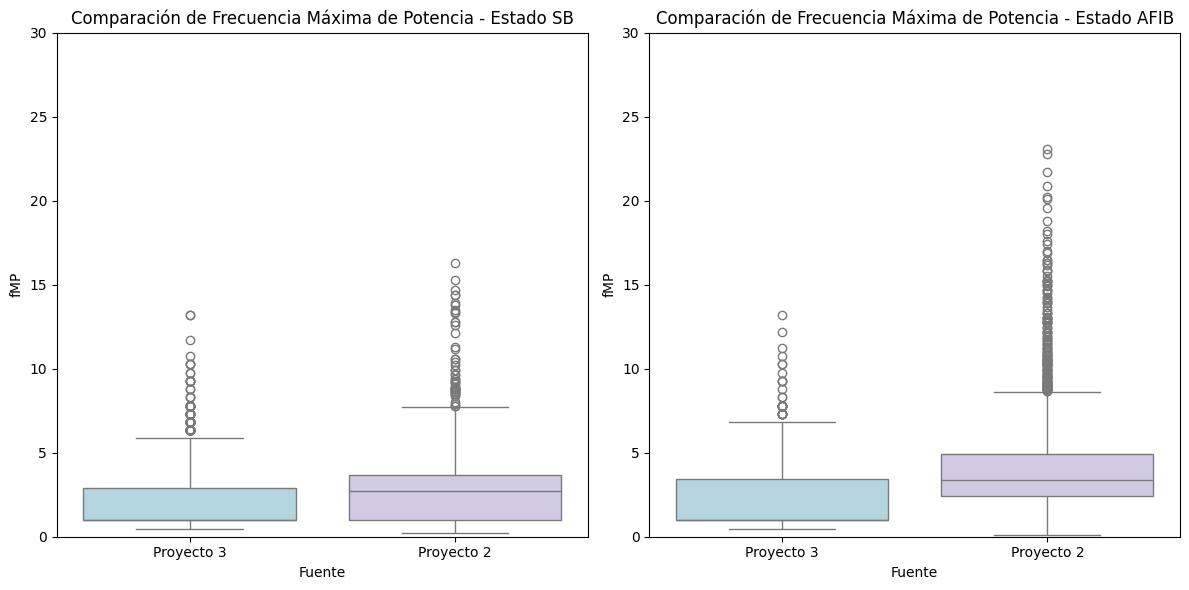

In [ ]:
import seaborn as sns

df_P3_SB = DataFrame_P3[DataFrame_P3['Estado'] == 'SB']
df_P2_SB = DataFrame_P2[DataFrame_P2['Estado'] == 'SB']

df_P3_AFIB = DataFrame_P3[DataFrame_P3['Estado'] == 'AFIB']
df_P2_AFIB = DataFrame_P2[DataFrame_P2['Estado'] == 'AFIB']


df_P3_SB['Fuente'] = 'Proyecto 3'
df_P2_SB['Fuente'] = 'Proyecto 2'
df_P3_AFIB['Fuente'] = 'Proyecto 3'
df_P2_AFIB['Fuente'] = 'Proyecto 2'

# CSe concatenan los datas por estado
df_SB = pd.concat([df_P3_SB, df_P2_SB])
df_AFIB = pd.concat([df_P3_AFIB, df_P2_AFIB])

plt.figure(figsize=(12, 6))

palette = {'Proyecto 3': 'lightblue', 'Proyecto 2': '#D1C4E9'}

#SB
plt.subplot(1, 2, 1)
sns.boxplot(data=df_SB, x='Fuente', y='fMP', hue='Fuente', palette=palette, legend=False)
plt.ylim(0, 30)
plt.title('Comparación de Frecuencia Máxima de Potencia - Estado SB')

#AFIB
plt.subplot(1, 2, 2)
sns.boxplot(data=df_AFIB, x='Fuente', y='fMP', hue='Fuente', palette=palette, legend=False)
plt.ylim(0, 30)
plt.title('Comparación de Frecuencia Máxima de Potencia - Estado AFIB')

plt.tight_layout()
plt.show()


Al comparar los resultados entre ambos proyectos, se puede evidenciar la existencia de diferencias notables en la distribución de la fMP, lo cual puede ser relacionado con las diferencias en los flujos de procesamiento empleados para el análisis de señales ECG.

En el proyecto 3, se observa una menor dispersión de los valores y una cantidad más reducida de valores atípicos, lo cual indica que los datos tienden a estar más concentrados alrededor de la mediana. Este resultado sugiere que el flujo de procesamiento en el proyecto 3 es más eficaz para mantener la consistencia y reducir las variaciones indeseadas en la señal, logrando así un mayor control sobre las interferencias no deseadas. En cambio, el proyecto 2 presenta una mayor dispersión y un número considerable de valores atípicos, lo que podría indicar que el flujo de procesamiento utilizado en este caso podría ser riguroso en cuanto a la eliminación de ruido, permitiendo la presencia de señales no deseadas que afectan la precisión del análisis.

En cuanto a la comparación entre los estados SB y AFIB en ambos proyectos, se observa que la fMP es mayor en AFIB, lo cual concuerda con las características fisiológicas de cada estado pues, la fibrilación auricular tiende a producir ritmos cardíacos más rápidos e irregulares, mientras que la bradicardia sinusal se asocia con ritmos más lentos y regulares [16, 17]. Esta tendencia, consistente en ambos proyectos, valida la efectividad de los flujos de procesamiento en capturar esta diferencia clave. No obstante, los valores extremos en cada estado también revelan una variabilidad notable entre pacientes, lo cual sugiere que podría ser beneficioso ajustar el flujo de procesamiento de acuerdo con las particularidades individuales.

Entonces, se tiene que, la combinación de técnicas de procesamiento empleadas en el proyecto 3 (filtros IIR y wavelet), permite optimizar la separación de los componentes relevantes de la señal, eliminando el ruido sin perder información valiosa sobre las características fisiológicas de cada estado, esto sugiere que dicho flujo es superior en términos de filtrado de ruido y preservación de la integridad de la señal ECG, ya que proporciona una fMP más consistente y controlada, lo que lo hace adecuado para este tipo de análisis que permite comparar distintos estados de ritmo cardíaco.  


# **Pruebas de hipótesis**

El análisis de las pruebas de hipótesis permite tomar decisiones estadísticas basadas en datos, con el fin de determinar si los resultados observados son significativos.

La prueba de normalidad se realizó mediante la **prueba de Kolmogorov-Smirnov** debido a que se trabajaron grupos caracterizados por tener más de 50 muestras [13]. Esta prueba fue realizada para los 4 grupos de interés (SB_P2, SB_P3, AFIB_P2, AFIB_P3), teniendo en cuenta las siguientes hipótesis:

* Ho: Los datos presentan una distribución normal. No se rechaza Ho.
* Ha: Los datos no presentan una distribución normal. Se rechaza Ho.

Seguidamente, se realizó la **prueba de homocedasticidad de Levene** para verificar si varios grupos de datos tienen varianzas iguales. Esta prueba es más robusta que otras pruebas de homocedasticidad (como la prueba de Bartlett) cuando los datos no siguen una distribución normal, lo que la hace adecuada para este análisis [14], por lo que se realizó para comparar tanto las poblaciones de estudio de los proyectos 1 y 2 (SB_P2 vs AFIB_P2 y SB_P3 vs AFIB_P3) para ver la variabilidad entre enfermedades y también se compararon los resultados obtenidos para las mismas enfermedades entre los 2 proyectos (SB_P2 vs SB_P3 y AFIB_P2 vs AFIB_P3) para evaluar si el flujo de procesamiento influye significativamente en los resultados según la fMP, teniendo en cuenta las siguientes hipótesis:

* Ho: Los grupos evaluados tienen varianzas iguales en términos de fMP. No se puede rechazar Ho.
* Ha: Los grupos evaluados tienen varianzas diferentes en términos de fMP. Se rechaza Ho.

**Independencia:** Se asume que los grupos son independientes.

Por último, como no se cumplen los supuestos de normalidad ni homocedasticidad para ningún caso, se opta por la realización de pruebas no paramétricas, en este caso, se emplea la **Prueba U de Mann-Whitney** para comparar si hay diferencias significativas entre las distribuciones de dos grupos independientes.  A diferencia de pruebas paramétricas como el t-test, la prueba de Mann-Whitney no requiere que los datos sigan una distribución normal, lo que la hace adecuada para este análisis [15]. Esta prueba fue realizada para comparar tanto las poblaciones de estudio de ambos proyectos como la variación entre mismas poblaciones con diferentes flujos de procesamiento según la fMP, teniendo en cuenta las siguientes hipótesis:

Para comparación entre las dos poblaciones evaluadas:
* Ho: Hay diferencias significativas en la tendencia central de fMP entre las poblaciones AFIB y SB del proyecto 2/3. No se rechaza Ho.
* Ha: No hay diferencias significativas en la tendencia central de fMP entre las poblaciones AFIB y SB del proyecto 2/3. Se rechaza Ho.

Para comparación entre los resultados de ambos proyectos entre mismas poblaciones:
* Ho: Hay diferencias significativas en la tendencia central de fMP entre los resultados obtenidos para SB/AFIB en los proyectos 2 y 3. No se rechaza Ho.
* Ha: No hay diferencias significativas en la tendencia central de fMP entre los resultados obtenidos para SB/AFIB en los proyectos 2 y 3. Se rechaza Ho.

In [ ]:
import pandas as pd
from scipy.stats import kstest, levene, mannwhitneyu


df_P3_SB = DataFrame_P3[DataFrame_P3['Estado'] == 'SB']
df_P2_SB = DataFrame_P2[DataFrame_P2['Estado'] == 'SB']
df_P3_AFIB = DataFrame_P3[DataFrame_P3['Estado'] == 'AFIB']
df_P2_AFIB = DataFrame_P2[DataFrame_P2['Estado'] == 'AFIB']

# Pruebas de normalidad de Kolmogorov-Smirnov
normalidad_resultados = {
    'P3_SB': kstest(df_P3_SB['fMP'], 'norm'),
    'P2_SB': kstest(df_P2_SB['fMP'], 'norm'),
    'P3_AFIB': kstest(df_P3_AFIB['fMP'], 'norm'),
    'P2_AFIB': kstest(df_P2_AFIB['fMP'], 'norm')
}

#Resultados normalidad
print("Resultados de normalidad (Kolmogorov-Smirnov):")
for grupo, resultado in normalidad_resultados.items():
    conclusion = "cumple normalidad" if resultado.pvalue > 0.05 else "no cumple normalidad"
    print(f"{grupo}: p-value = {resultado.pvalue:.4f} ({conclusion})")

# Pruebas de homocedasticidad de Levene entre los grupos especificados
homocedasticidad_resultados = {
    'SB_P2_vs_SB_P3': levene(df_P2_SB['fMP'], df_P3_SB['fMP']),
    'AFIB_P2_vs_AFIB_P3': levene(df_P2_AFIB['fMP'], df_P3_AFIB['fMP']),
    'SB_P3_vs_AFIB_P3': levene(df_P3_SB['fMP'], df_P3_AFIB['fMP']),
    'SB_P2_vs_AFIB_P2': levene(df_P2_SB['fMP'], df_P2_AFIB['fMP'])
}

# Comparaciones de grupos usando Mann-Whitney U
comparaciones = {
    'SB_P2_vs_SB_P3': mannwhitneyu(df_P2_SB['fMP'], df_P3_SB['fMP']),
    'AFIB_P2_vs_AFIB_P3': mannwhitneyu(df_P2_AFIB['fMP'], df_P3_AFIB['fMP']),
    'SB_P3_vs_AFIB_P3': mannwhitneyu(df_P3_SB['fMP'], df_P3_AFIB['fMP']),
    'SB_P2_vs_AFIB_P2': mannwhitneyu(df_P2_SB['fMP'], df_P2_AFIB['fMP'])
}

# Resulytados homocedasticidad
print("\nResultados de homocedasticidad (Levene):")
for comparacion, resultado in homocedasticidad_resultados.items():
    conclusion = "cumple homocedasticidad" if resultado.pvalue > 0.05 else "no cumple homocedasticidad"
    print(f"{comparacion}: p-value = {resultado.pvalue:.4f} ({conclusion})")

#Resultados Mann-Whitney U
print("\nResultados de comparación (Mann-Whitney U):")
for comparacion, resultado in comparaciones.items():
    diff_significativa = "hay diferencias significativas" if resultado.pvalue < 0.05 else "no hay diferencias significativas"
    print(f"{comparacion}: estadístico = {resultado.statistic:.4f}, p-value = {resultado.pvalue:.4f} ({diff_significativa})")



Resultados de normalidad (Kolmogorov-Smirnov):
P3_SB: p-value = 0.0000 (no cumple normalidad)
P2_SB: p-value = 0.0000 (no cumple normalidad)
P3_AFIB: p-value = 0.0000 (no cumple normalidad)
P2_AFIB: p-value = 0.0000 (no cumple normalidad)

Resultados de homocedasticidad (Levene):
SB_P2_vs_SB_P3: p-value = 0.0000 (no cumple homocedasticidad)
AFIB_P2_vs_AFIB_P3: p-value = 0.0000 (no cumple homocedasticidad)
SB_P3_vs_AFIB_P3: p-value = 0.0007 (no cumple homocedasticidad)
SB_P2_vs_AFIB_P2: p-value = 0.0000 (no cumple homocedasticidad)

Resultados de comparación (Mann-Whitney U):
SB_P2_vs_SB_P3: estadístico = 9399215.0000, p-value = 0.0000 (hay diferencias significativas)
AFIB_P2_vs_AFIB_P3: estadístico = 2460955.0000, p-value = 0.0000 (hay diferencias significativas)
SB_P3_vs_AFIB_P3: estadístico = 2994228.0000, p-value = 0.0000 (hay diferencias significativas)
SB_P2_vs_AFIB_P2: estadístico = 2141031.5000, p-value = 0.0000 (hay diferencias significativas)


### **1. Normalidad:**
Los resultados muestran que las arritmias evaluadas no siguen una distribución normal en términos de frecuencia de máxima potencia. Esto implica que los métodos estadísticos paramétricos tradicionales no son apropiados para realizar comparaciones entre los grupos. En su lugar, se utilizan pruebas no paramétricas, como la prueba U de Mann-Whitney.

### **2. Homocedasticidad:**

Al comparar los resultados obtenidos para los mismos tipos de arritmia entre los proyectos 2 y 3 (SB_P2 vs SB_P3 y AFIB_P2 vs AFIB_P3), se evidencia que hay diferencias significativas en términos de varianza para las frecuencias de máxima potencia encontradas. Estos resultados indican la influencia del flujo de procesamiento empleado para el análisis de señales y su efecto en los resultados finales.

Por otro lado, en este proyecto se vuelve a confirmar las diferencias existentes entre los grupos AFIB y SB en términos de fMP, lo cual indica que la dispersión de los valores de ambas variables no es igual entre grupos. Esto también se vio representando en el BoxPlot, en el que se evidencia que el grupo AFIB muestra una mayor variabilidad en la frecuencia de máxima de potencia (mayor rango intercuartíluco), mientras que el grupo SB puede tener valores más concentrados o menos dispersos, como se discutió anteriormente. Estas diferencias en la variabilidad indican que existen diferencias entre la actividad eléctrica cardíaca en los sujetos con AFIB respecto a aquellos con SB.


### **3. Prueba U de Mann Whitney:**

Los resultados de la prueba U de Mann-Whitney revelan diferencias estadísticamente significativas entre todos los pares comparados (p-value = 0.0000), lo que indica que las distribuciones de frecuencia máxima de potencia (fMP) son diferentes en cada caso. Esto refleja la influencia de los distintos flujos de procesamiento utilizados en los proyectos y también evidencia las diferencias intrínsecas entre los estados fisiológicos de AFIB y SB.

Se evidencia una diferencia significativa en la fMP entre los datos de bradicardia sinusal y fibrilación auricular procesados en el proyecto 2 y el proyecto 3. Esto sugiere que los métodos de procesamiento de señales ECG utilizados en cada proyecto afectan la distribución de la fMP en SB. El flujo del proyecto 3 parece tener un efecto que concentra más los datos, lo cual podría relacionarse con un control mejorado de ruido y señal, como se observa en los BoxPlot.

Por otro lado, las diferencias observadas en las medianas o tendencias entre los grupos AFIB y SB confirman que los dos grupos **se comportan de manera distinta en términos de sus patrones eléctricos cardíacos.** Esto sugiere que AFIB y SB no solo difieren en la dispersión de los datos, sino también en la posición central o tendencia de sus distribuciones.  Estos resultados se mantienen claros y consistentes en los dos proyectos, alineándose con las características fisiológicas de cada estado.

La mayor varianza en fMP para el grupo AFIB refleja una actividad eléctrica más caótica o impredecible, lo cual es consistente con la naturaleza de esta arritmia, caracterizada por impulsos irregulares y rápidos [16]. Por otro lado, el grupo SB, al tener menos variabilidad, probablemente presenta una actividad eléctrica más regulada y predecible [17].



# **Conclusiones**

* La comparación entre los proyectos 2 y 3 demuestra que el flujo de procesamiento tiene un impacto notable en la dispersión y consistencia de la frecuencia de máxima potencia (fMP), lo que indica que dicho flujo es un factor crucial para obtener datos consistentes y confiables en análisis ECG.

* Los resultados sugieren que las diferencias entre SB y AFIb no son aleatorias, sino que reflejan variaciones fisiológicas reales en las señales de ECG que son relevantes para la caracterización de cada condición, tal que en ambos proyectos, se observa que la fMP es consistentemente mayor en el estado AFIB en comparación con SB. Esto es coherente con las características fisiológicas de estos estados, donde AFIB se asocia a un ritmo más rápido e irregular y SB a uno más lento y regular. Esta tendencia confirma la efectividad de los flujos de procesamiento empleados para captar las diferencias fisiológicas entre ambos estados.


* Es imprescindible el ajuste de los flujos de procesamiento de acuerdo con las características de las señales a analizar para mejorar la precisión en el análisis, ya que este es un factor determinante en los resultados según se conserve la integridad de la señal de interés. En el caso de señales ECG, se evidenció la efectividad de los filtros wavelet adecuados debido a su adaptabilidad ante señales no estacionarias, permitiendo que se preserve la morfología de la señal a la vez que se produce una buena reducción del ruido.



# **Referencias**
[1] Zheng, J., Chu, H., Struppa, D., Zhang, J., Yacoub, S. M., El-Askary, H., Chang, A., Ehwerhemuepha, L., Abudayyeh, I., Barrett, A., Fu, G., Yao, H., Li, D., Guo, H., & Rakovski, C. (2020). Optimal Multi-Stage Arrhythmia Classification Approach. Scientific Reports 2020 10:1, 10(1), 1–17. https://doi.org/10.1038/s41598-020-59821-7

[2] C. Li, C. Zheng y C. Tai. “Detection of ECG characteristic points using wavelet transforms - PubMed”. PubMed. Accedido el 8 de noviembre de 2024. [En línea]. Disponible: https://pubmed.ncbi.nlm.nih.gov/7851927/

[3] S. Z. Mahmoodabadi. “ECG feature extraction based on multiresolution wavelet transform - pubmed”. PubMed. Accedido el 6 de noviembre de 2024. [En línea]. Disponible: https://pubmed.ncbi.nlm.nih.gov/17281084/

[4] “Feature extraction from ECG signals using wavelet transforms fordisease diagnostics”. Taylor & Francis online. Accedido el 6 de noviembre de 2024. [En línea]. Disponible: https://www-tandfonline-com.udea.lookproxy.com/doi/abs/10.1080/00207720210167159

[5] J. L. Romero. “Análisis de señales electrocardiográficas usando técnicas de procesamiento digital”. Universidad Oberta de Catalunya. Accedido el 6 de noviembre de 2024. [En línea]. Disponible: https://openaccess.uoc.edu/bitstream/10609/40186/6/jlorenzoroTFC0115memoria.pdf

[6] Fundamentos Teóricos. (s.f.). Test Page for the HTTP Server on Red Hat Enterprise Linux. https://biblus.us.es/bibing/proyectos/abreproy/11375/fichero/MEMORIA%2FFundamentos+teoricos.pdf

[7] Diseño de filtros IIR- MATLAB & Simulink- MathWorks América Latina. (s.f.). MathWorks - Creador de MATLAB y Simulink - MATLAB y Simulink - MATLAB & Simulink. https://la.mathworks.com/help/signal/ug/iir-filter-design.html

[8] M. Kumngern. “0.5 V Fifth-Order Butterworth Low-Pass Filter Using Multiple-Input OTA for ECG Applications - PubMed”. PubMed. Accedido el 5 de noviembre de 2024. [En línea]. Disponible: https://pubmed.ncbi.nlm.nih.gov/33371335/

[9] C. Watford. “Understanding ecg filtering”. rigacci.org [rigacci.org]. Accedido el 6 de noviembre de 2024. [En línea]. Disponible: https://www2.rigacci.org/wiki/lib/exe/fetch.php/tecnica/misc/ecg90a/understanding-ecg-filtering.pdf

[10] Bendat, J. S., & Piersol, A. G. (2011). Random Data: Analysis and Measurement Procedures (4th ed.). Wiley-Interscience.
Este libro ofrece una cobertura amplia sobre técnicas de análisis de datos aleatorios, incluyendo métodos de estimación de espectros.

[11] detrend — Manual de SciPy v1.14.1. (n.d.). Retrieved October 19, 2024, from https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.detrend.html

[12] Muñoz Marí, J. (1997, febrero). Compresión de ecg en tiempo real con el dsp tms320c25. Universitat de València. https://www.uv.es/jordi/pdf/tesina.pdf

[13] RPubs - Prueba de normalidad de Shapiro-Wilk. (s.f.). RPubs. https://rpubs.com/F3rnando/507482

[14] T-Test, chi-square, ANOVA, regression, correlation... (s.f.). Calculadora estadí­stica en línea: Pruebas de hipótesis, prueba t, chi-cuadrado, regresión, correlación, análisis de varianza, análisis de conglomerados. https://datatab.es/tutorial/levene-test

[15] SPSS statistics subscription - early access. (s.f.). IBM - United States. https://www.ibm.com/docs/es/spss-statistics/beta?topic=tests-mann-whitney-u-test

[16] Pacheco, L., & Azucena, L. (2024, 15 de marzo). Vista de Bradicardia sinusal: Caso clínico. MQRInvestigar. https://www.investigarmqr.com/ojs/index.php/mqr/article/view/984/3731

[17] Acosta Tiburcio, Y. R. (2017). Validez diagnóstica del sistema kardia Mobile Microlife y hallazgos ecocardiográficos en pacientes con fibrilación auricular en el servicio de cardiología del Hospital Dr. Salvador B. Gautier septiembre 2016 - agosto 2017. Tesis de Grado. https://repositorio.unphu.edu.do/handle/123456789/780